In [1]:
%matplotlib inline

import argparse
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

import gym
from gym import wrappers, logger
from gridworld_env import gridworld

from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from agents import RandomAgent

import torch

# Problem 1 (a)-(c)

##### Solution: Please see the code in the directory - gridworld_env.py. 

Note that to use the constructor of the custom environment with the official `gym.make` function, we need to first register the environment. Please see the `gridworld_env/__init__.py` on how to register the environment. The constructor of the GridWorld takes the reward matrix via kwargs dictionary defined in `__init__.py`. The environment defined in Example 3.5 (Sutton et al.) is defined with the environment-id: `GridWorld-v0`. A brief summary of the GridWorld class is as follows:

    Description:
        Gridworld environment as specified in Sutton et al. Example 3.5
    Observation: 
        Discrete (width*height)
    Actions:
        Discrete (4)
        North, South, West, East
    Reward:
        Reward as specified in Example 3.5 of Sutton et al.
        The reward matrix is specified in __init__.py
    Starting State:
        Starting state is a location on the grid
    Episode Termination:
        Episode terminates after MAX_STEPS_PER_EPISODE


# Problem 1 (d)

##### Solution: The custom environment is working and meets the required specification as we will see below when we estimate the state-value function using a random agent.


# Problem 1 (e)

##### Solution: The environment  `GridWorld-v0` corresponds to Example 3.5 (Sutton and Barto). 
##### Please see the definition in `gridworld_env/__init__.py`.

# Problem 2 (a)-(b)

In [26]:
env_id = 'GridWorld-v0'
seed = 1234

In [27]:
env = gym.make(env_id)
env.seed(seed)
agent = RandomAgent(env.action_space)
num_episodes = 20000
reward = 0.
done = False

In [28]:
alpha = 0.01
gamma = 0.9

In [29]:
V = np.zeros((env.h, env.w))
for episode in trange(1, num_episodes+1):
    ob = env.reset()
    s_old = env.position
    rewards = []
    while True:
        action = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)
        s_new = env.position
        
        V[s_old[0], s_old[1]] = V[s_old[0], s_old[1]] + alpha*(reward + gamma*V[s_new[0], s_new[1]] - V[s_old[0], s_old[1]]) 
        rewards.append(reward)
        if done:
            break

        s_old = s_new
        # Note there's no env.render() here. But the environment still can open window and
        # render if asked by env.monitor: it calls env.render('rgb_array') to record video.
        # Video is not recorded every episode, see capped_cubic_video_schedule for details.
    
    if episode % 5000 == 0:
        print ('Episode Number: {:d} | Total Reward: {:.4f} '.format(episode, np.sum(rewards)))

# Close the env and write monitor result info to disk
env.close()

 26%|██▌       | 5117/20000 [00:05<00:15, 970.70it/s] 

Episode Number: 5000 | Total Reward: -5.0000 


 51%|█████     | 10199/20000 [00:10<00:09, 986.38it/s]

Episode Number: 10000 | Total Reward: 12.0000 


 76%|███████▌  | 15185/20000 [00:15<00:04, 978.10it/s]

Episode Number: 15000 | Total Reward: -8.0000 


100%|██████████| 20000/20000 [00:20<00:00, 973.81it/s]

Episode Number: 20000 | Total Reward: 0.0000 


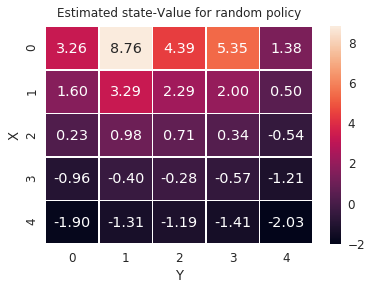

In [31]:
sns.set(font_scale = 1.2)
ax = sns.heatmap(V, annot=True, fmt=".2f", linewidths=.5)
ax.set_title('Estimated state-Value for random policy', pad=10, fontsize=12)

# We use the convention followed by numpy, 
# i.e. top-left is (0,0) and x is along the hieght of the grid

ax.set_ylabel('X') # X corresponds to the first dimension
ax.set_xlabel('Y') # Y corresponds to the second dimension
plt.show()

# VPG

## Problem 3 (a)

##### Solution: Trajectory length is set to 20: See the GridWorld class defined in gridworld_env/gridworld.py file

## Problem 3 (b)

##### Solution: I had to adapt the VPG code and actor-critic code to make the discrete space work. In particular, following files were adapted/modified from the original spinningup code:
* vpg.py (env.obs.shape[0] -> env.obs.n) + Return total reward for plotting.
* custom_actor_critic.py (line 15: observation_sapce.shape[0] -> observation_space.n)

In [32]:
from spinup.utils.run_utils import setup_logger_kwargs
logger_kwargs = setup_logger_kwargs('vpg', seed, data_dir='model/')

# The following two files were adapted to make
# discrete observation space work with vpg.
from custom_actor_critic import MLPActorCritic
from vpg import vpg as vpg_pytorch

In [33]:
hid = 32
num_layers = 2
gamma = 0.9
num_epochs = 2000
cpu = 2

MAX_STEPS_PER_EPISODE = gridworld.GridWorld.MAX_STEPS_PER_EPISODE
steps = MAX_STEPS_PER_EPISODE

In [34]:
epoch_reward = vpg_pytorch(lambda : gym.make(env_id), actor_critic=MLPActorCritic,
                            ac_kwargs=dict(hidden_sizes=[hid]*num_layers), gamma=gamma, 
                            seed=seed, steps_per_epoch=steps, epochs=num_epochs,
                            logger_kwargs=logger_kwargs, max_ep_len=MAX_STEPS_PER_EPISODE)


Logging data to model/vpg/vpg_s1234/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "env_fn":	"<function <lambda> at 0x7f7ec0dd0170>",
    "epochs":	5000,
    "exp_name":	"vpg",
    "gamma":	0.9,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f7ec0e0f090>":	{
            "epoch_dict":	{},
            "exp_name":	"vpg",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"model/vpg/vpg_s1234",
            "output_file":	{
                "<_io.TextIOWrapper name='model/vpg/vpg_s1234/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"vpg",
        "output_dir":	"model/vpg/vpg_s1234"
    },
    "max_ep_len":	50,
    "pi_lr":	0.0003,
    "save_freq"

---------------------------------------
|             Epoch |               9 |
|      AverageEpRet |             -11 |
|          StdEpRet |               0 |
|          MaxEpRet |             -11 |
|          MinEpRet |             -11 |
|             EpLen |              50 |
|      AverageVVals |            1.67 |
|          StdVVals |            2.24 |
|          MaxVVals |            7.58 |
|          MinVVals |          -0.979 |
| TotalEnvInteracts |             500 |
|            LossPi |          0.0112 |
|             LossV |            9.41 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -8.81 |
|           Entropy |            1.38 |
|                KL |       -7.15e-09 |
|              Time |            1.72 |
---------------------------------------
---------------------------------------
|             Epoch |              10 |
|      AverageEpRet |               5 |
|          StdEpRet |               0 |
|          MaxEpRet |               5 |


---------------------------------------
|             Epoch |              20 |
|      AverageEpRet |               5 |
|          StdEpRet |               0 |
|          MaxEpRet |               5 |
|          MinEpRet |               5 |
|             EpLen |              50 |
|      AverageVVals |           -1.06 |
|          StdVVals |             2.4 |
|          MaxVVals |            5.67 |
|          MinVVals |           -3.63 |
| TotalEnvInteracts |        1.05e+03 |
|            LossPi |          0.0146 |
|             LossV |            7.36 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -5.79 |
|           Entropy |            1.38 |
|                KL |        1.43e-08 |
|              Time |            3.66 |
---------------------------------------
---------------------------------------
|             Epoch |              21 |
|      AverageEpRet |               7 |
|          StdEpRet |               0 |
|          MaxEpRet |               7 |


---------------------------------------
|             Epoch |              31 |
|      AverageEpRet |               2 |
|          StdEpRet |               0 |
|          MaxEpRet |               2 |
|          MinEpRet |               2 |
|             EpLen |              50 |
|      AverageVVals |           0.241 |
|          StdVVals |            2.99 |
|          MaxVVals |            7.59 |
|          MinVVals |           -3.63 |
| TotalEnvInteracts |         1.6e+03 |
|            LossPi |        -0.00237 |
|             LossV |            9.58 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -7.79 |
|           Entropy |            1.38 |
|                KL |        4.77e-09 |
|              Time |            5.74 |
---------------------------------------
---------------------------------------
|             Epoch |              32 |
|      AverageEpRet |              -1 |
|          StdEpRet |               0 |
|          MaxEpRet |              -1 |


---------------------------------------
|             Epoch |              42 |
|      AverageEpRet |              -7 |
|          StdEpRet |               0 |
|          MaxEpRet |              -7 |
|          MinEpRet |              -7 |
|             EpLen |              50 |
|      AverageVVals |             2.6 |
|          StdVVals |            1.71 |
|          MaxVVals |            5.98 |
|          MinVVals |          -0.279 |
| TotalEnvInteracts |        2.15e+03 |
|            LossPi |         0.00485 |
|             LossV |            15.4 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -13.3 |
|           Entropy |            1.38 |
|                KL |       -4.77e-09 |
|              Time |            7.59 |
---------------------------------------
---------------------------------------
|             Epoch |              43 |
|      AverageEpRet |               2 |
|          StdEpRet |               0 |
|          MaxEpRet |               2 |


---------------------------------------
|             Epoch |              53 |
|      AverageEpRet |              -4 |
|          StdEpRet |               0 |
|          MaxEpRet |              -4 |
|          MinEpRet |              -4 |
|             EpLen |              50 |
|      AverageVVals |            1.32 |
|          StdVVals |            1.34 |
|          MaxVVals |            6.74 |
|          MinVVals |          -0.951 |
| TotalEnvInteracts |         2.7e+03 |
|            LossPi |        -0.00587 |
|             LossV |             7.6 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -5.25 |
|           Entropy |            1.38 |
|                KL |        4.77e-09 |
|              Time |            9.51 |
---------------------------------------
---------------------------------------
|             Epoch |              54 |
|      AverageEpRet |              -5 |
|          StdEpRet |               0 |
|          MaxEpRet |              -5 |


---------------------------------------
|             Epoch |              64 |
|      AverageEpRet |              -5 |
|          StdEpRet |               0 |
|          MaxEpRet |              -5 |
|          MinEpRet |              -5 |
|             EpLen |              50 |
|      AverageVVals |           0.668 |
|          StdVVals |             1.7 |
|          MaxVVals |            6.39 |
|          MinVVals |           -1.19 |
| TotalEnvInteracts |        3.25e+03 |
|            LossPi |         -0.0361 |
|             LossV |            3.32 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.19 |
|           Entropy |            1.38 |
|                KL |        2.38e-09 |
|              Time |            10.9 |
---------------------------------------
---------------------------------------
|             Epoch |              65 |
|      AverageEpRet |               9 |
|          StdEpRet |               0 |
|          MaxEpRet |               9 |


---------------------------------------
|             Epoch |              75 |
|      AverageEpRet |               7 |
|          StdEpRet |               0 |
|          MaxEpRet |               7 |
|          MinEpRet |               7 |
|             EpLen |              50 |
|      AverageVVals |             1.1 |
|          StdVVals |             2.3 |
|          MaxVVals |            9.09 |
|          MinVVals |          -0.864 |
| TotalEnvInteracts |         3.8e+03 |
|            LossPi |         -0.0301 |
|             LossV |            3.92 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.57 |
|           Entropy |            1.38 |
|                KL |       -7.15e-09 |
|              Time |            12.7 |
---------------------------------------
---------------------------------------
|             Epoch |              76 |
|      AverageEpRet |               2 |
|          StdEpRet |               0 |
|          MaxEpRet |               2 |


---------------------------------------
|             Epoch |              86 |
|      AverageEpRet |               2 |
|          StdEpRet |               0 |
|          MaxEpRet |               2 |
|          MinEpRet |               2 |
|             EpLen |              50 |
|      AverageVVals |          -0.707 |
|          StdVVals |             1.4 |
|          MaxVVals |            5.74 |
|          MinVVals |            -2.7 |
| TotalEnvInteracts |        4.35e+03 |
|            LossPi |         -0.0547 |
|             LossV |             5.9 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -3.1 |
|           Entropy |            1.37 |
|                KL |       -9.54e-09 |
|              Time |            14.6 |
---------------------------------------
---------------------------------------
|             Epoch |              87 |
|      AverageEpRet |              20 |
|          StdEpRet |               0 |
|          MaxEpRet |              20 |


---------------------------------------
|             Epoch |              97 |
|      AverageEpRet |              15 |
|          StdEpRet |               0 |
|          MaxEpRet |              15 |
|          MinEpRet |              15 |
|             EpLen |              50 |
|      AverageVVals |            3.48 |
|          StdVVals |            2.19 |
|          MaxVVals |            8.64 |
|          MinVVals |           -1.85 |
| TotalEnvInteracts |         4.9e+03 |
|            LossPi |         -0.0783 |
|             LossV |            6.11 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.89 |
|           Entropy |            1.37 |
|                KL |       -2.15e-08 |
|              Time |            16.4 |
---------------------------------------
---------------------------------------
|             Epoch |              98 |
|      AverageEpRet |              16 |
|          StdEpRet |               0 |
|          MaxEpRet |              16 |


---------------------------------------
|             Epoch |             108 |
|      AverageEpRet |               9 |
|          StdEpRet |               0 |
|          MaxEpRet |               9 |
|          MinEpRet |               9 |
|             EpLen |              50 |
|      AverageVVals |            1.38 |
|          StdVVals |            3.47 |
|          MaxVVals |            9.79 |
|          MinVVals |           -2.07 |
| TotalEnvInteracts |        5.45e+03 |
|            LossPi |         -0.0575 |
|             LossV |            6.97 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.16 |
|           Entropy |            1.36 |
|                KL |       -9.54e-09 |
|              Time |            18.3 |
---------------------------------------
---------------------------------------
|             Epoch |             109 |
|      AverageEpRet |               1 |
|          StdEpRet |               0 |
|          MaxEpRet |               1 |


---------------------------------------
|             Epoch |             119 |
|      AverageEpRet |               2 |
|          StdEpRet |               0 |
|          MaxEpRet |               2 |
|          MinEpRet |               2 |
|             EpLen |              50 |
|      AverageVVals |            3.53 |
|          StdVVals |             2.4 |
|          MaxVVals |            8.79 |
|          MinVVals |           0.175 |
| TotalEnvInteracts |           6e+03 |
|            LossPi |         -0.0157 |
|             LossV |            10.5 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -8.75 |
|           Entropy |            1.35 |
|                KL |       -9.54e-09 |
|              Time |            20.3 |
---------------------------------------
---------------------------------------
|             Epoch |             120 |
|      AverageEpRet |              -2 |
|          StdEpRet |               0 |
|          MaxEpRet |              -2 |


---------------------------------------
|             Epoch |             130 |
|      AverageEpRet |               2 |
|          StdEpRet |               0 |
|          MaxEpRet |               2 |
|          MinEpRet |               2 |
|             EpLen |              50 |
|      AverageVVals |             1.2 |
|          StdVVals |            1.58 |
|          MaxVVals |            7.94 |
|          MinVVals |          -0.913 |
| TotalEnvInteracts |        6.55e+03 |
|            LossPi |           -0.12 |
|             LossV |            7.43 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.85 |
|           Entropy |            1.35 |
|                KL |       -1.19e-09 |
|              Time |            22.2 |
---------------------------------------
---------------------------------------
|             Epoch |             131 |
|      AverageEpRet |              16 |
|          StdEpRet |               0 |
|          MaxEpRet |              16 |


---------------------------------------
|             Epoch |             141 |
|      AverageEpRet |              28 |
|          StdEpRet |               0 |
|          MaxEpRet |              28 |
|          MinEpRet |              28 |
|             EpLen |              50 |
|      AverageVVals |            4.38 |
|          StdVVals |               2 |
|          MaxVVals |            9.19 |
|          MinVVals |            1.38 |
| TotalEnvInteracts |         7.1e+03 |
|            LossPi |          -0.104 |
|             LossV |            9.51 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.72 |
|           Entropy |            1.33 |
|                KL |        7.15e-09 |
|              Time |              24 |
---------------------------------------
---------------------------------------
|             Epoch |             142 |
|      AverageEpRet |              32 |
|          StdEpRet |               0 |
|          MaxEpRet |              32 |


---------------------------------------
|             Epoch |             152 |
|      AverageEpRet |              41 |
|          StdEpRet |               0 |
|          MaxEpRet |              41 |
|          MinEpRet |              41 |
|             EpLen |              50 |
|      AverageVVals |            5.54 |
|          StdVVals |            1.77 |
|          MaxVVals |            9.89 |
|          MinVVals |            2.95 |
| TotalEnvInteracts |        7.65e+03 |
|            LossPi |         -0.0992 |
|             LossV |            7.25 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -5.15 |
|           Entropy |            1.32 |
|                KL |       -1.55e-08 |
|              Time |              26 |
---------------------------------------
---------------------------------------
|             Epoch |             153 |
|      AverageEpRet |              18 |
|          StdEpRet |               0 |
|          MaxEpRet |              18 |


---------------------------------------
|             Epoch |             163 |
|      AverageEpRet |              10 |
|          StdEpRet |               0 |
|          MaxEpRet |              10 |
|          MinEpRet |              10 |
|             EpLen |              50 |
|      AverageVVals |             3.9 |
|          StdVVals |            2.33 |
|          MaxVVals |            10.4 |
|          MinVVals |           0.427 |
| TotalEnvInteracts |         8.2e+03 |
|            LossPi |          -0.157 |
|             LossV |            8.97 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.22 |
|           Entropy |            1.31 |
|                KL |        1.07e-08 |
|              Time |            28.1 |
---------------------------------------
---------------------------------------
|             Epoch |             164 |
|      AverageEpRet |              24 |
|          StdEpRet |               0 |
|          MaxEpRet |              24 |


---------------------------------------
|             Epoch |             174 |
|      AverageEpRet |              -9 |
|          StdEpRet |               0 |
|          MaxEpRet |              -9 |
|          MinEpRet |              -9 |
|             EpLen |              50 |
|      AverageVVals |            6.19 |
|          StdVVals |            1.68 |
|          MaxVVals |            10.2 |
|          MinVVals |            3.75 |
| TotalEnvInteracts |        8.75e+03 |
|            LossPi |          -0.161 |
|             LossV |              48 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -46.3 |
|           Entropy |            1.28 |
|                KL |        9.54e-09 |
|              Time |              30 |
---------------------------------------
---------------------------------------
|             Epoch |             175 |
|      AverageEpRet |              45 |
|          StdEpRet |               0 |
|          MaxEpRet |              45 |


---------------------------------------
|             Epoch |             185 |
|      AverageEpRet |              13 |
|          StdEpRet |               0 |
|          MaxEpRet |              13 |
|          MinEpRet |              13 |
|             EpLen |              50 |
|      AverageVVals |            6.31 |
|          StdVVals |            1.98 |
|          MaxVVals |            10.8 |
|          MinVVals |            3.28 |
| TotalEnvInteracts |         9.3e+03 |
|            LossPi |         -0.0607 |
|             LossV |            16.7 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -9.61 |
|           Entropy |            1.25 |
|                KL |       -1.31e-08 |
|              Time |              32 |
---------------------------------------
---------------------------------------
|             Epoch |             186 |
|      AverageEpRet |               5 |
|          StdEpRet |               0 |
|          MaxEpRet |               5 |


---------------------------------------
|             Epoch |             196 |
|      AverageEpRet |              32 |
|          StdEpRet |               0 |
|          MaxEpRet |              32 |
|          MinEpRet |              32 |
|             EpLen |              50 |
|      AverageVVals |            5.76 |
|          StdVVals |            2.22 |
|          MaxVVals |            12.5 |
|          MinVVals |            3.41 |
| TotalEnvInteracts |        9.85e+03 |
|            LossPi |          -0.193 |
|             LossV |            8.35 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.64 |
|           Entropy |            1.22 |
|                KL |       -2.26e-08 |
|              Time |            33.8 |
---------------------------------------
---------------------------------------
|             Epoch |             197 |
|      AverageEpRet |              18 |
|          StdEpRet |               0 |
|          MaxEpRet |              18 |


---------------------------------------
|             Epoch |             207 |
|      AverageEpRet |              14 |
|          StdEpRet |               0 |
|          MaxEpRet |              14 |
|          MinEpRet |              14 |
|             EpLen |              50 |
|      AverageVVals |            7.19 |
|          StdVVals |            2.41 |
|          MaxVVals |            13.4 |
|          MinVVals |             2.1 |
| TotalEnvInteracts |        1.04e+04 |
|            LossPi |          -0.111 |
|             LossV |            23.9 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -13.1 |
|           Entropy |            1.21 |
|                KL |        1.31e-08 |
|              Time |            35.6 |
---------------------------------------
---------------------------------------
|             Epoch |             208 |
|      AverageEpRet |              22 |
|          StdEpRet |               0 |
|          MaxEpRet |              22 |


---------------------------------------
|             Epoch |             218 |
|      AverageEpRet |              19 |
|          StdEpRet |               0 |
|          MaxEpRet |              19 |
|          MinEpRet |              19 |
|             EpLen |              50 |
|      AverageVVals |            8.76 |
|          StdVVals |            2.82 |
|          MaxVVals |            13.8 |
|          MinVVals |            3.07 |
| TotalEnvInteracts |         1.1e+04 |
|            LossPi |          -0.189 |
|             LossV |            46.9 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -38.2 |
|           Entropy |            1.18 |
|                KL |       -3.22e-08 |
|              Time |            37.2 |
---------------------------------------
---------------------------------------
|             Epoch |             219 |
|      AverageEpRet |              33 |
|          StdEpRet |               0 |
|          MaxEpRet |              33 |


---------------------------------------
|             Epoch |             229 |
|      AverageEpRet |              29 |
|          StdEpRet |               0 |
|          MaxEpRet |              29 |
|          MinEpRet |              29 |
|             EpLen |              50 |
|      AverageVVals |            7.34 |
|          StdVVals |            1.57 |
|          MaxVVals |            11.5 |
|          MinVVals |            4.47 |
| TotalEnvInteracts |        1.15e+04 |
|            LossPi |          -0.108 |
|             LossV |            8.97 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.03 |
|           Entropy |            1.14 |
|                KL |       -2.62e-08 |
|              Time |            38.9 |
---------------------------------------
---------------------------------------
|             Epoch |             230 |
|      AverageEpRet |              56 |
|          StdEpRet |               0 |
|          MaxEpRet |              56 |


---------------------------------------
|             Epoch |             240 |
|      AverageEpRet |              29 |
|          StdEpRet |               0 |
|          MaxEpRet |              29 |
|          MinEpRet |              29 |
|             EpLen |              50 |
|      AverageVVals |            5.33 |
|          StdVVals |            3.77 |
|          MaxVVals |              13 |
|          MinVVals |           -1.35 |
| TotalEnvInteracts |        1.20e+04 |
|            LossPi |           0.026 |
|             LossV |            13.8 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -7.6 |
|           Entropy |            1.08 |
|                KL |       -1.67e-08 |
|              Time |            40.8 |
---------------------------------------
---------------------------------------
|             Epoch |             241 |
|      AverageEpRet |              21 |
|          StdEpRet |               0 |
|          MaxEpRet |              21 |


---------------------------------------
|             Epoch |             251 |
|      AverageEpRet |              -5 |
|          StdEpRet |               0 |
|          MaxEpRet |              -5 |
|          MinEpRet |              -5 |
|             EpLen |              50 |
|      AverageVVals |            7.65 |
|          StdVVals |            2.31 |
|          MaxVVals |              14 |
|          MinVVals |            3.14 |
| TotalEnvInteracts |        1.26e+04 |
|            LossPi |         -0.0881 |
|             LossV |            90.9 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -72.8 |
|           Entropy |            1.07 |
|                KL |       -2.38e-09 |
|              Time |            42.9 |
---------------------------------------
---------------------------------------
|             Epoch |             252 |
|      AverageEpRet |              44 |
|          StdEpRet |               0 |
|          MaxEpRet |              44 |


---------------------------------------
|             Epoch |             262 |
|      AverageEpRet |              42 |
|          StdEpRet |               0 |
|          MaxEpRet |              42 |
|          MinEpRet |              42 |
|             EpLen |              50 |
|      AverageVVals |            5.81 |
|          StdVVals |            1.98 |
|          MaxVVals |            12.6 |
|          MinVVals |            3.84 |
| TotalEnvInteracts |        1.32e+04 |
|            LossPi |          -0.157 |
|             LossV |            12.1 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.17 |
|           Entropy |            1.01 |
|                KL |        1.19e-08 |
|              Time |            45.6 |
---------------------------------------
---------------------------------------
|             Epoch |             263 |
|      AverageEpRet |              36 |
|          StdEpRet |               0 |
|          MaxEpRet |              36 |


---------------------------------------
|             Epoch |             273 |
|      AverageEpRet |              31 |
|          StdEpRet |               0 |
|          MaxEpRet |              31 |
|          MinEpRet |              31 |
|             EpLen |              50 |
|      AverageVVals |            8.99 |
|          StdVVals |            3.04 |
|          MaxVVals |            14.9 |
|          MinVVals |            1.34 |
| TotalEnvInteracts |        1.37e+04 |
|            LossPi |           0.126 |
|             LossV |            18.8 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -8.37 |
|           Entropy |           0.985 |
|                KL |       -2.62e-08 |
|              Time |            47.8 |
---------------------------------------
---------------------------------------
|             Epoch |             274 |
|      AverageEpRet |              29 |
|          StdEpRet |               0 |
|          MaxEpRet |              29 |


---------------------------------------
|             Epoch |             284 |
|      AverageEpRet |              35 |
|          StdEpRet |               0 |
|          MaxEpRet |              35 |
|          MinEpRet |              35 |
|             EpLen |              50 |
|      AverageVVals |            7.57 |
|          StdVVals |            2.88 |
|          MaxVVals |            13.5 |
|          MinVVals |           0.278 |
| TotalEnvInteracts |        1.42e+04 |
|            LossPi |          -0.179 |
|             LossV |            13.3 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.31 |
|           Entropy |           0.981 |
|                KL |       -2.38e-09 |
|              Time |            50.1 |
---------------------------------------
---------------------------------------
|             Epoch |             285 |
|      AverageEpRet |              37 |
|          StdEpRet |               0 |
|          MaxEpRet |              37 |


---------------------------------------
|             Epoch |             295 |
|      AverageEpRet |              59 |
|          StdEpRet |               0 |
|          MaxEpRet |              59 |
|          MinEpRet |              59 |
|             EpLen |              50 |
|      AverageVVals |            10.2 |
|          StdVVals |            2.57 |
|          MaxVVals |            14.3 |
|          MinVVals |            6.04 |
| TotalEnvInteracts |        1.48e+04 |
|            LossPi |          -0.135 |
|             LossV |            6.52 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.97 |
|           Entropy |           0.868 |
|                KL |        2.86e-08 |
|              Time |            51.7 |
---------------------------------------
---------------------------------------
|             Epoch |             296 |
|      AverageEpRet |              52 |
|          StdEpRet |               0 |
|          MaxEpRet |              52 |


---------------------------------------
|             Epoch |             306 |
|      AverageEpRet |              63 |
|          StdEpRet |               0 |
|          MaxEpRet |              63 |
|          MinEpRet |              63 |
|             EpLen |              50 |
|      AverageVVals |            5.91 |
|          StdVVals |            5.01 |
|          MaxVVals |            14.8 |
|          MinVVals |            1.61 |
| TotalEnvInteracts |        1.54e+04 |
|            LossPi |         -0.0351 |
|             LossV |            64.1 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -49.9 |
|           Entropy |           0.903 |
|                KL |       -4.77e-09 |
|              Time |            53.8 |
---------------------------------------
---------------------------------------
|             Epoch |             307 |
|      AverageEpRet |              42 |
|          StdEpRet |               0 |
|          MaxEpRet |              42 |


---------------------------------------
|             Epoch |             317 |
|      AverageEpRet |              66 |
|          StdEpRet |               0 |
|          MaxEpRet |              66 |
|          MinEpRet |              66 |
|             EpLen |              50 |
|      AverageVVals |            11.4 |
|          StdVVals |            2.25 |
|          MaxVVals |            15.6 |
|          MinVVals |            6.93 |
| TotalEnvInteracts |        1.59e+04 |
|            LossPi |          -0.177 |
|             LossV |            10.6 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.23 |
|           Entropy |           0.849 |
|                KL |               0 |
|              Time |            55.9 |
---------------------------------------
---------------------------------------
|             Epoch |             318 |
|      AverageEpRet |              62 |
|          StdEpRet |               0 |
|          MaxEpRet |              62 |


---------------------------------------
|             Epoch |             328 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            8.72 |
|          StdVVals |            2.82 |
|          MaxVVals |            14.3 |
|          MinVVals |             3.6 |
| TotalEnvInteracts |        1.64e+04 |
|            LossPi |         -0.0864 |
|             LossV |            41.1 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -26.2 |
|           Entropy |           0.695 |
|                KL |       -4.53e-08 |
|              Time |              58 |
---------------------------------------
---------------------------------------
|             Epoch |             329 |
|      AverageEpRet |              26 |
|          StdEpRet |               0 |
|          MaxEpRet |              26 |


---------------------------------------
|             Epoch |             339 |
|      AverageEpRet |              44 |
|          StdEpRet |               0 |
|          MaxEpRet |              44 |
|          MinEpRet |              44 |
|             EpLen |              50 |
|      AverageVVals |            11.4 |
|          StdVVals |            3.15 |
|          MaxVVals |            16.9 |
|          MinVVals |            6.04 |
| TotalEnvInteracts |         1.7e+04 |
|            LossPi |         -0.0774 |
|             LossV |            17.1 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.95 |
|           Entropy |           0.767 |
|                KL |               0 |
|              Time |            59.8 |
---------------------------------------
---------------------------------------
|             Epoch |             340 |
|      AverageEpRet |              55 |
|          StdEpRet |               0 |
|          MaxEpRet |              55 |


---------------------------------------
|             Epoch |             350 |
|      AverageEpRet |              64 |
|          StdEpRet |               0 |
|          MaxEpRet |              64 |
|          MinEpRet |              64 |
|             EpLen |              50 |
|      AverageVVals |            10.4 |
|          StdVVals |            2.02 |
|          MaxVVals |            15.1 |
|          MinVVals |            6.03 |
| TotalEnvInteracts |        1.76e+04 |
|            LossPi |         -0.0425 |
|             LossV |            18.4 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -10.2 |
|           Entropy |           0.642 |
|                KL |        4.77e-09 |
|              Time |            61.3 |
---------------------------------------
---------------------------------------
|             Epoch |             351 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |             361 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |
|          MinEpRet |              74 |
|             EpLen |              50 |
|      AverageVVals |            8.07 |
|          StdVVals |            4.94 |
|          MaxVVals |            16.2 |
|          MinVVals |           0.668 |
| TotalEnvInteracts |        1.81e+04 |
|            LossPi |          -0.199 |
|             LossV |            42.8 |
|       DeltaLossPi |               0 |
|        DeltaLossV |             -32 |
|           Entropy |           0.677 |
|                KL |        2.38e-08 |
|              Time |            62.7 |
---------------------------------------
---------------------------------------
|             Epoch |             362 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             372 |
|      AverageEpRet |              49 |
|          StdEpRet |               0 |
|          MaxEpRet |              49 |
|          MinEpRet |              49 |
|             EpLen |              50 |
|      AverageVVals |            8.43 |
|          StdVVals |            3.49 |
|          MaxVVals |            15.8 |
|          MinVVals |            2.24 |
| TotalEnvInteracts |        1.86e+04 |
|            LossPi |          0.0531 |
|             LossV |            38.6 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.83 |
|           Entropy |           0.721 |
|                KL |       -2.38e-08 |
|              Time |            64.8 |
---------------------------------------
---------------------------------------
|             Epoch |             373 |
|      AverageEpRet |              77 |
|          StdEpRet |               0 |
|          MaxEpRet |              77 |


---------------------------------------
|             Epoch |             383 |
|      AverageEpRet |              78 |
|          StdEpRet |               0 |
|          MaxEpRet |              78 |
|          MinEpRet |              78 |
|             EpLen |              50 |
|      AverageVVals |            12.8 |
|          StdVVals |            2.89 |
|          MaxVVals |              17 |
|          MinVVals |            7.89 |
| TotalEnvInteracts |        1.92e+04 |
|            LossPi |          -0.206 |
|             LossV |            8.34 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.53 |
|           Entropy |           0.613 |
|                KL |       -1.91e-08 |
|              Time |            66.9 |
---------------------------------------
---------------------------------------
|             Epoch |             384 |
|      AverageEpRet |               7 |
|          StdEpRet |               0 |
|          MaxEpRet |               7 |


---------------------------------------
|             Epoch |             394 |
|      AverageEpRet |              59 |
|          StdEpRet |               0 |
|          MaxEpRet |              59 |
|          MinEpRet |              59 |
|             EpLen |              50 |
|      AverageVVals |            14.9 |
|          StdVVals |            2.05 |
|          MaxVVals |            17.6 |
|          MinVVals |            9.54 |
| TotalEnvInteracts |        1.98e+04 |
|            LossPi |         -0.0748 |
|             LossV |            9.41 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.02 |
|           Entropy |           0.573 |
|                KL |        2.74e-08 |
|              Time |            68.6 |
---------------------------------------
---------------------------------------
|             Epoch |             395 |
|      AverageEpRet |              58 |
|          StdEpRet |               0 |
|          MaxEpRet |              58 |


---------------------------------------
|             Epoch |             405 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |
|          MinEpRet |              74 |
|             EpLen |              50 |
|      AverageVVals |            14.3 |
|          StdVVals |            2.39 |
|          MaxVVals |            16.8 |
|          MinVVals |            4.18 |
| TotalEnvInteracts |        2.03e+04 |
|            LossPi |        -0.00588 |
|             LossV |            3.89 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.02 |
|           Entropy |           0.466 |
|                KL |       -4.77e-09 |
|              Time |            70.6 |
---------------------------------------
---------------------------------------
|             Epoch |             406 |
|      AverageEpRet |              67 |
|          StdEpRet |               0 |
|          MaxEpRet |              67 |


---------------------------------------
|             Epoch |             416 |
|      AverageEpRet |              61 |
|          StdEpRet |               0 |
|          MaxEpRet |              61 |
|          MinEpRet |              61 |
|             EpLen |              50 |
|      AverageVVals |            15.8 |
|          StdVVals |            1.86 |
|          MaxVVals |            18.1 |
|          MinVVals |              10 |
| TotalEnvInteracts |        2.08e+04 |
|            LossPi |          -0.243 |
|             LossV |            10.7 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.27 |
|           Entropy |             0.5 |
|                KL |        2.38e-09 |
|              Time |            72.9 |
---------------------------------------
---------------------------------------
|             Epoch |             417 |
|      AverageEpRet |              66 |
|          StdEpRet |               0 |
|          MaxEpRet |              66 |


---------------------------------------
|             Epoch |             427 |
|      AverageEpRet |              68 |
|          StdEpRet |               0 |
|          MaxEpRet |              68 |
|          MinEpRet |              68 |
|             EpLen |              50 |
|      AverageVVals |            15.6 |
|          StdVVals |            2.76 |
|          MaxVVals |            19.4 |
|          MinVVals |            6.69 |
| TotalEnvInteracts |        2.14e+04 |
|            LossPi |          -0.408 |
|             LossV |            8.52 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.67 |
|           Entropy |           0.411 |
|                KL |       -7.15e-09 |
|              Time |            75.1 |
---------------------------------------
---------------------------------------
|             Epoch |             428 |
|      AverageEpRet |              37 |
|          StdEpRet |               0 |
|          MaxEpRet |              37 |


---------------------------------------
|             Epoch |             438 |
|      AverageEpRet |              40 |
|          StdEpRet |               0 |
|          MaxEpRet |              40 |
|          MinEpRet |              40 |
|             EpLen |              50 |
|      AverageVVals |            12.8 |
|          StdVVals |            2.37 |
|          MaxVVals |            18.6 |
|          MinVVals |            9.86 |
| TotalEnvInteracts |         2.2e+04 |
|            LossPi |          -0.144 |
|             LossV |            39.5 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -20.2 |
|           Entropy |            0.58 |
|                KL |       -1.19e-08 |
|              Time |            76.5 |
---------------------------------------
---------------------------------------
|             Epoch |             439 |
|      AverageEpRet |              32 |
|          StdEpRet |               0 |
|          MaxEpRet |              32 |


---------------------------------------
|             Epoch |             449 |
|      AverageEpRet |              57 |
|          StdEpRet |               0 |
|          MaxEpRet |              57 |
|          MinEpRet |              57 |
|             EpLen |              50 |
|      AverageVVals |            17.3 |
|          StdVVals |            1.78 |
|          MaxVVals |            19.5 |
|          MinVVals |            12.9 |
| TotalEnvInteracts |        2.25e+04 |
|            LossPi |          -0.146 |
|             LossV |            34.6 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -25.1 |
|           Entropy |           0.465 |
|                KL |               0 |
|              Time |            78.1 |
---------------------------------------
---------------------------------------
|             Epoch |             450 |
|      AverageEpRet |              45 |
|          StdEpRet |               0 |
|          MaxEpRet |              45 |


---------------------------------------
|             Epoch |             460 |
|      AverageEpRet |              36 |
|          StdEpRet |               0 |
|          MaxEpRet |              36 |
|          MinEpRet |              36 |
|             EpLen |              50 |
|      AverageVVals |            14.8 |
|          StdVVals |            2.48 |
|          MaxVVals |            20.5 |
|          MinVVals |            12.3 |
| TotalEnvInteracts |        2.30e+04 |
|            LossPi |          -0.125 |
|             LossV |            63.2 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -32.5 |
|           Entropy |           0.563 |
|                KL |        -3.1e-08 |
|              Time |            80.2 |
---------------------------------------
---------------------------------------
|             Epoch |             461 |
|      AverageEpRet |              68 |
|          StdEpRet |               0 |
|          MaxEpRet |              68 |


---------------------------------------
|             Epoch |             471 |
|      AverageEpRet |              53 |
|          StdEpRet |               0 |
|          MaxEpRet |              53 |
|          MinEpRet |              53 |
|             EpLen |              50 |
|      AverageVVals |            16.2 |
|          StdVVals |            1.93 |
|          MaxVVals |            18.4 |
|          MinVVals |            7.69 |
| TotalEnvInteracts |        2.36e+04 |
|            LossPi |          -0.276 |
|             LossV |            28.8 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -14.6 |
|           Entropy |           0.433 |
|                KL |        5.96e-09 |
|              Time |            82.2 |
---------------------------------------
---------------------------------------
|             Epoch |             472 |
|      AverageEpRet |              77 |
|          StdEpRet |               0 |
|          MaxEpRet |              77 |


---------------------------------------
|             Epoch |             482 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            18.2 |
|          StdVVals |            3.61 |
|          MaxVVals |            22.8 |
|          MinVVals |            8.62 |
| TotalEnvInteracts |        2.42e+04 |
|            LossPi |          -0.016 |
|             LossV |            4.95 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.62 |
|           Entropy |           0.346 |
|                KL |       -5.01e-08 |
|              Time |            84.2 |
---------------------------------------
---------------------------------------
|             Epoch |             483 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |             493 |
|      AverageEpRet |              64 |
|          StdEpRet |               0 |
|          MaxEpRet |              64 |
|          MinEpRet |              64 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.65 |
|          MaxVVals |            18.4 |
|          MinVVals |            11.3 |
| TotalEnvInteracts |        2.47e+04 |
|            LossPi |          -0.283 |
|             LossV |            16.4 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -12.4 |
|           Entropy |           0.432 |
|                KL |        9.54e-09 |
|              Time |              86 |
---------------------------------------
---------------------------------------
|             Epoch |             494 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |             504 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |              17 |
|          StdVVals |            3.18 |
|          MaxVVals |            22.1 |
|          MinVVals |            12.4 |
| TotalEnvInteracts |        2.52e+04 |
|            LossPi |          -0.228 |
|             LossV |            6.74 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.687 |
|           Entropy |           0.364 |
|                KL |       -3.58e-08 |
|              Time |            88.1 |
---------------------------------------
---------------------------------------
|             Epoch |             505 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             515 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |            11.5 |
|          StdVVals |            2.59 |
|          MaxVVals |            15.6 |
|          MinVVals |            6.15 |
| TotalEnvInteracts |        2.58e+04 |
|            LossPi |           0.224 |
|             LossV |            48.4 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -42.6 |
|           Entropy |            0.34 |
|                KL |        9.54e-09 |
|              Time |            90.1 |
---------------------------------------
---------------------------------------
|             Epoch |             516 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |             526 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.3 |
|          StdVVals |            1.64 |
|          MaxVVals |            18.1 |
|          MinVVals |            10.8 |
| TotalEnvInteracts |        2.64e+04 |
|            LossPi |          -0.355 |
|             LossV |            2.54 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.729 |
|           Entropy |           0.195 |
|                KL |               0 |
|              Time |            91.7 |
---------------------------------------
---------------------------------------
|             Epoch |             527 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |             537 |
|      AverageEpRet |              51 |
|          StdEpRet |               0 |
|          MaxEpRet |              51 |
|          MinEpRet |              51 |
|             EpLen |              50 |
|      AverageVVals |            15.3 |
|          StdVVals |            1.49 |
|          MaxVVals |            17.6 |
|          MinVVals |            10.8 |
| TotalEnvInteracts |        2.69e+04 |
|            LossPi |          -0.365 |
|             LossV |            23.6 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -11.4 |
|           Entropy |           0.408 |
|                KL |       -1.43e-08 |
|              Time |            93.4 |
---------------------------------------
---------------------------------------
|             Epoch |             538 |
|      AverageEpRet |              70 |
|          StdEpRet |               0 |
|          MaxEpRet |              70 |


---------------------------------------
|             Epoch |             548 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.2 |
|          StdVVals |            1.85 |
|          MaxVVals |            18.2 |
|          MinVVals |            9.99 |
| TotalEnvInteracts |        2.74e+04 |
|            LossPi |         0.00772 |
|             LossV |           0.241 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.198 |
|           Entropy |           0.169 |
|                KL |               0 |
|              Time |            95.2 |
---------------------------------------
---------------------------------------
|             Epoch |             549 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             559 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |
|          MinEpRet |              89 |
|             EpLen |              50 |
|      AverageVVals |            19.4 |
|          StdVVals |            2.83 |
|          MaxVVals |            23.8 |
|          MinVVals |            15.6 |
| TotalEnvInteracts |         2.8e+04 |
|            LossPi |          -0.241 |
|             LossV |            5.82 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.95 |
|           Entropy |           0.213 |
|                KL |        1.43e-08 |
|              Time |            97.3 |
---------------------------------------
---------------------------------------
|             Epoch |             560 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             570 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            17.6 |
|          StdVVals |            1.18 |
|          MaxVVals |            19.1 |
|          MinVVals |            15.7 |
| TotalEnvInteracts |        2.86e+04 |
|            LossPi |          -0.716 |
|             LossV |             4.4 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -3.4 |
|           Entropy |           0.169 |
|                KL |        7.15e-09 |
|              Time |            99.2 |
---------------------------------------
---------------------------------------
|             Epoch |             571 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |             581 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |
|          MinEpRet |              99 |
|             EpLen |              50 |
|      AverageVVals |            17.8 |
|          StdVVals |            3.05 |
|          MaxVVals |            22.4 |
|          MinVVals |            13.9 |
| TotalEnvInteracts |        2.91e+04 |
|            LossPi |          -0.378 |
|             LossV |            2.99 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -2.5 |
|           Entropy |           0.156 |
|                KL |       -1.91e-08 |
|              Time |             101 |
---------------------------------------
---------------------------------------
|             Epoch |             582 |
|      AverageEpRet |              60 |
|          StdEpRet |               0 |
|          MaxEpRet |              60 |


---------------------------------------
|             Epoch |             592 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.1 |
|          StdVVals |            2.92 |
|          MaxVVals |            23.3 |
|          MinVVals |            13.2 |
| TotalEnvInteracts |        2.96e+04 |
|            LossPi |           0.101 |
|             LossV |            2.03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.55 |
|           Entropy |           0.173 |
|                KL |       -2.38e-09 |
|              Time |             103 |
---------------------------------------
---------------------------------------
|             Epoch |             593 |
|      AverageEpRet |              73 |
|          StdEpRet |               0 |
|          MaxEpRet |              73 |


---------------------------------------
|             Epoch |             603 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |
|          MinEpRet |              74 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            4.54 |
|          MaxVVals |            22.8 |
|          MinVVals |             1.8 |
| TotalEnvInteracts |        3.02e+04 |
|            LossPi |          -0.181 |
|             LossV |            16.3 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -2.7 |
|           Entropy |           0.294 |
|                KL |               0 |
|              Time |             105 |
---------------------------------------
---------------------------------------
|             Epoch |             604 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |             614 |
|      AverageEpRet |              59 |
|          StdEpRet |               0 |
|          MaxEpRet |              59 |
|          MinEpRet |              59 |
|             EpLen |              50 |
|      AverageVVals |            17.7 |
|          StdVVals |            3.43 |
|          MaxVVals |            22.9 |
|          MinVVals |            2.53 |
| TotalEnvInteracts |        3.08e+04 |
|            LossPi |          -0.205 |
|             LossV |            47.5 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -30.6 |
|           Entropy |           0.413 |
|                KL |       -1.91e-08 |
|              Time |             107 |
---------------------------------------
---------------------------------------
|             Epoch |             615 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             625 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            15.8 |
|          StdVVals |            1.84 |
|          MaxVVals |              18 |
|          MinVVals |            10.8 |
| TotalEnvInteracts |        3.13e+04 |
|            LossPi |          0.0137 |
|             LossV |            1.04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.961 |
|           Entropy |           0.155 |
|                KL |        8.34e-09 |
|              Time |             109 |
---------------------------------------
---------------------------------------
|             Epoch |             626 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             636 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |
|          MinEpRet |              74 |
|             EpLen |              50 |
|      AverageVVals |            15.9 |
|          StdVVals |            4.28 |
|          MaxVVals |            22.8 |
|          MinVVals |            3.23 |
| TotalEnvInteracts |        3.18e+04 |
|            LossPi |            0.41 |
|             LossV |            10.7 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -8.26 |
|           Entropy |           0.151 |
|                KL |        4.77e-09 |
|              Time |             110 |
---------------------------------------
---------------------------------------
|             Epoch |             637 |
|      AverageEpRet |              79 |
|          StdEpRet |               0 |
|          MaxEpRet |              79 |


---------------------------------------
|             Epoch |             647 |
|      AverageEpRet |              68 |
|          StdEpRet |               0 |
|          MaxEpRet |              68 |
|          MinEpRet |              68 |
|             EpLen |              50 |
|      AverageVVals |              17 |
|          StdVVals |            2.68 |
|          MaxVVals |            18.9 |
|          MinVVals |            9.01 |
| TotalEnvInteracts |        3.24e+04 |
|            LossPi |           -0.21 |
|             LossV |            2.01 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.74 |
|           Entropy |           0.196 |
|                KL |        1.19e-09 |
|              Time |             112 |
---------------------------------------
---------------------------------------
|             Epoch |             648 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |             658 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            18.4 |
|          StdVVals |            3.23 |
|          MaxVVals |            23.2 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |         3.3e+04 |
|            LossPi |        -0.00207 |
|             LossV |            1.97 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.75 |
|           Entropy |           0.128 |
|                KL |               0 |
|              Time |             114 |
---------------------------------------
---------------------------------------
|             Epoch |             659 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |             669 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.2 |
|          StdVVals |            2.93 |
|          MaxVVals |            23.6 |
|          MinVVals |            15.3 |
| TotalEnvInteracts |        3.35e+04 |
|            LossPi |          0.0694 |
|             LossV |           0.471 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.432 |
|           Entropy |           0.127 |
|                KL |               0 |
|              Time |             116 |
---------------------------------------
---------------------------------------
|             Epoch |             670 |
|      AverageEpRet |              73 |
|          StdEpRet |               0 |
|          MaxEpRet |              73 |


---------------------------------------
|             Epoch |             680 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            17.3 |
|          StdVVals |            1.28 |
|          MaxVVals |            18.9 |
|          MinVVals |            15.8 |
| TotalEnvInteracts |        3.40e+04 |
|            LossPi |           0.075 |
|             LossV |           0.319 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.309 |
|           Entropy |           0.124 |
|                KL |       -4.77e-09 |
|              Time |             118 |
---------------------------------------
---------------------------------------
|             Epoch |             681 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             691 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |
|          MinEpRet |              89 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            2.89 |
|          MaxVVals |            21.9 |
|          MinVVals |            12.2 |
| TotalEnvInteracts |        3.46e+04 |
|            LossPi |          -0.158 |
|             LossV |            6.15 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.66 |
|           Entropy |           0.177 |
|                KL |        1.19e-08 |
|              Time |             121 |
---------------------------------------
---------------------------------------
|             Epoch |             692 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             702 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            15.7 |
|          StdVVals |            2.08 |
|          MaxVVals |            21.7 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        3.52e+04 |
|            LossPi |          -0.294 |
|             LossV |            2.94 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.69 |
|           Entropy |           0.189 |
|                KL |        5.96e-09 |
|              Time |             123 |
---------------------------------------
---------------------------------------
|             Epoch |             703 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |             713 |
|      AverageEpRet |              69 |
|          StdEpRet |               0 |
|          MaxEpRet |              69 |
|          MinEpRet |              69 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            2.06 |
|          MaxVVals |            18.8 |
|          MinVVals |            10.9 |
| TotalEnvInteracts |        3.57e+04 |
|            LossPi |          -0.518 |
|             LossV |            4.01 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.73 |
|           Entropy |           0.202 |
|                KL |       -1.91e-08 |
|              Time |             124 |
---------------------------------------
---------------------------------------
|             Epoch |             714 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |             724 |
|      AverageEpRet |              61 |
|          StdEpRet |               0 |
|          MaxEpRet |              61 |
|          MinEpRet |              61 |
|             EpLen |              50 |
|      AverageVVals |            15.1 |
|          StdVVals |             3.4 |
|          MaxVVals |            18.7 |
|          MinVVals |            4.78 |
| TotalEnvInteracts |        3.62e+04 |
|            LossPi |          -0.379 |
|             LossV |            5.04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.97 |
|           Entropy |           0.263 |
|                KL |        7.15e-09 |
|              Time |             126 |
---------------------------------------
---------------------------------------
|             Epoch |             725 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             735 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |            19.1 |
|          StdVVals |            2.82 |
|          MaxVVals |            23.6 |
|          MinVVals |            12.4 |
| TotalEnvInteracts |        3.68e+04 |
|            LossPi |          -0.078 |
|             LossV |            1.48 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.871 |
|           Entropy |           0.182 |
|                KL |       -9.54e-09 |
|              Time |             127 |
---------------------------------------
---------------------------------------
|             Epoch |             736 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             746 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |
|          MinEpRet |              74 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |             1.4 |
|          MaxVVals |            19.8 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        3.74e+04 |
|            LossPi |         -0.0992 |
|             LossV |            2.75 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.31 |
|           Entropy |            0.16 |
|                KL |        2.38e-08 |
|              Time |             129 |
---------------------------------------
---------------------------------------
|             Epoch |             747 |
|      AverageEpRet |              68 |
|          StdEpRet |               0 |
|          MaxEpRet |              68 |


---------------------------------------
|             Epoch |             757 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |
|          MinEpRet |              99 |
|             EpLen |              50 |
|      AverageVVals |            19.5 |
|          StdVVals |            3.22 |
|          MaxVVals |            24.1 |
|          MinVVals |            10.3 |
| TotalEnvInteracts |        3.79e+04 |
|            LossPi |          -0.153 |
|             LossV |            6.57 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.11 |
|           Entropy |           0.182 |
|                KL |               0 |
|              Time |             132 |
---------------------------------------
---------------------------------------
|             Epoch |             758 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             768 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            18.6 |
|          StdVVals |            2.99 |
|          MaxVVals |            23.1 |
|          MinVVals |            11.8 |
| TotalEnvInteracts |        3.84e+04 |
|            LossPi |          0.0191 |
|             LossV |            2.26 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.22 |
|           Entropy |           0.124 |
|                KL |               0 |
|              Time |             135 |
---------------------------------------
---------------------------------------
|             Epoch |             769 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |             779 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |              17 |
|          StdVVals |            1.61 |
|          MaxVVals |              22 |
|          MinVVals |            15.2 |
| TotalEnvInteracts |         3.9e+04 |
|            LossPi |          -0.154 |
|             LossV |            1.06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.01 |
|           Entropy |           0.123 |
|                KL |               0 |
|              Time |             137 |
---------------------------------------
---------------------------------------
|             Epoch |             780 |
|      AverageEpRet |              73 |
|          StdEpRet |               0 |
|          MaxEpRet |              73 |


---------------------------------------
|             Epoch |             790 |
|      AverageEpRet |              44 |
|          StdEpRet |               0 |
|          MaxEpRet |              44 |
|          MinEpRet |              44 |
|             EpLen |              50 |
|      AverageVVals |            17.6 |
|          StdVVals |            1.79 |
|          MaxVVals |            23.9 |
|          MinVVals |            14.3 |
| TotalEnvInteracts |        3.96e+04 |
|            LossPi |          -0.531 |
|             LossV |            75.8 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -69.1 |
|           Entropy |           0.481 |
|                KL |        4.77e-09 |
|              Time |             139 |
---------------------------------------
---------------------------------------
|             Epoch |             791 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             801 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            17.5 |
|          StdVVals |            2.95 |
|          MaxVVals |              22 |
|          MinVVals |            10.3 |
| TotalEnvInteracts |        4.01e+04 |
|            LossPi |         -0.0143 |
|             LossV |            4.63 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -3.9 |
|           Entropy |           0.109 |
|                KL |               0 |
|              Time |             141 |
---------------------------------------
---------------------------------------
|             Epoch |             802 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             812 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            18.4 |
|          StdVVals |            3.51 |
|          MaxVVals |            23.5 |
|          MinVVals |            9.09 |
| TotalEnvInteracts |        4.06e+04 |
|            LossPi |          -0.169 |
|             LossV |            4.53 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.43 |
|           Entropy |           0.142 |
|                KL |        4.77e-09 |
|              Time |             143 |
---------------------------------------
---------------------------------------
|             Epoch |             813 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             823 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            3.02 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.1 |
| TotalEnvInteracts |        4.12e+04 |
|            LossPi |          -0.134 |
|             LossV |            0.48 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.298 |
|           Entropy |           0.137 |
|                KL |        4.53e-08 |
|              Time |             145 |
---------------------------------------
---------------------------------------
|             Epoch |             824 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |


---------------------------------------
|             Epoch |             834 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            2.87 |
|          MaxVVals |            24.2 |
|          MinVVals |              16 |
| TotalEnvInteracts |        4.18e+04 |
|            LossPi |          0.0982 |
|             LossV |          0.0467 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.045 |
|           Entropy |          0.0644 |
|                KL |               0 |
|              Time |             147 |
---------------------------------------
---------------------------------------
|             Epoch |             835 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |             845 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |
|          MinEpRet |              99 |
|             EpLen |              50 |
|      AverageVVals |            19.3 |
|          StdVVals |            3.12 |
|          MaxVVals |            23.9 |
|          MinVVals |              12 |
| TotalEnvInteracts |        4.23e+04 |
|            LossPi |         -0.0609 |
|             LossV |           0.598 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.471 |
|           Entropy |           0.127 |
|                KL |               0 |
|              Time |             148 |
---------------------------------------
---------------------------------------
|             Epoch |             846 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             856 |
|      AverageEpRet |              70 |
|          StdEpRet |               0 |
|          MaxEpRet |              70 |
|          MinEpRet |              70 |
|             EpLen |              50 |
|      AverageVVals |              16 |
|          StdVVals |            1.95 |
|          MaxVVals |            18.4 |
|          MinVVals |            10.8 |
| TotalEnvInteracts |        4.28e+04 |
|            LossPi |          -0.432 |
|             LossV |            2.92 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.03 |
|           Entropy |            0.17 |
|                KL |        1.91e-08 |
|              Time |             150 |
---------------------------------------
---------------------------------------
|             Epoch |             857 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |             867 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.4 |
|          StdVVals |             3.5 |
|          MaxVVals |            24.3 |
|          MinVVals |            10.3 |
| TotalEnvInteracts |        4.34e+04 |
|            LossPi |          -0.274 |
|             LossV |            1.85 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.25 |
|           Entropy |          0.0995 |
|                KL |               0 |
|              Time |             152 |
---------------------------------------
---------------------------------------
|             Epoch |             868 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             878 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         4.4e+04 |
|            LossPi |          0.0473 |
|             LossV |         0.00471 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00471 |
|           Entropy |           0.093 |
|                KL |               0 |
|              Time |             154 |
---------------------------------------
---------------------------------------
|             Epoch |             879 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             889 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        4.45e+04 |
|            LossPi |          0.0613 |
|             LossV |        1.86e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.71e-05 |
|           Entropy |           0.071 |
|                KL |               0 |
|              Time |             156 |
---------------------------------------
---------------------------------------
|             Epoch |             890 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             900 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |              17 |
|          StdVVals |            1.57 |
|          MaxVVals |            21.3 |
|          MinVVals |            15.1 |
| TotalEnvInteracts |        4.50e+04 |
|            LossPi |         -0.0998 |
|             LossV |             1.3 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.19 |
|           Entropy |          0.0952 |
|                KL |       -9.54e-09 |
|              Time |             158 |
---------------------------------------
---------------------------------------
|             Epoch |             901 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |             911 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |
|          MinEpRet |              89 |
|             EpLen |              50 |
|      AverageVVals |            19.4 |
|          StdVVals |            3.23 |
|          MaxVVals |            24.3 |
|          MinVVals |            11.9 |
| TotalEnvInteracts |        4.56e+04 |
|            LossPi |            0.14 |
|             LossV |           0.696 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.491 |
|           Entropy |           0.104 |
|                KL |               0 |
|              Time |             160 |
---------------------------------------
---------------------------------------
|             Epoch |             912 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |


---------------------------------------
|             Epoch |             922 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        4.62e+04 |
|            LossPi |          0.0288 |
|             LossV |           0.047 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0307 |
|           Entropy |             0.1 |
|                KL |        1.07e-08 |
|              Time |             161 |
---------------------------------------
---------------------------------------
|             Epoch |             923 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             933 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |            20.1 |
|          StdVVals |            2.84 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        4.67e+04 |
|            LossPi |          -0.371 |
|             LossV |            2.72 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.68 |
|           Entropy |           0.153 |
|                KL |        2.38e-09 |
|              Time |             163 |
---------------------------------------
---------------------------------------
|             Epoch |             934 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |             944 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |
|          MinEpRet |              99 |
|             EpLen |              50 |
|      AverageVVals |            18.4 |
|          StdVVals |            2.86 |
|          MaxVVals |            22.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        4.72e+04 |
|            LossPi |           0.141 |
|             LossV |            2.68 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.43 |
|           Entropy |           0.121 |
|                KL |       -2.38e-09 |
|              Time |             164 |
---------------------------------------
---------------------------------------
|             Epoch |             945 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |


---------------------------------------
|             Epoch |             955 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.75 |
|          MaxVVals |            20.8 |
|          MinVVals |            11.1 |
| TotalEnvInteracts |        4.78e+04 |
|            LossPi |          -0.142 |
|             LossV |           0.932 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.872 |
|           Entropy |           0.101 |
|                KL |               0 |
|              Time |             167 |
---------------------------------------
---------------------------------------
|             Epoch |             956 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             966 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.94 |
|          MaxVVals |            24.4 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        4.84e+04 |
|            LossPi |        0.000349 |
|             LossV |         0.00251 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00203 |
|           Entropy |          0.0581 |
|                KL |               0 |
|              Time |             169 |
---------------------------------------
---------------------------------------
|             Epoch |             967 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |             977 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            17.7 |
|          StdVVals |            1.14 |
|          MaxVVals |            19.1 |
|          MinVVals |            16.3 |
| TotalEnvInteracts |        4.89e+04 |
|            LossPi |          0.0834 |
|             LossV |           0.781 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.679 |
|           Entropy |          0.0945 |
|                KL |        7.15e-09 |
|              Time |             172 |
---------------------------------------
---------------------------------------
|             Epoch |             978 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |             988 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |
|          MinEpRet |              99 |
|             EpLen |              50 |
|      AverageVVals |            19.1 |
|          StdVVals |            2.99 |
|          MaxVVals |            23.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        4.94e+04 |
|            LossPi |          -0.214 |
|             LossV |             1.3 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.11 |
|           Entropy |          0.0997 |
|                KL |               0 |
|              Time |             174 |
---------------------------------------
---------------------------------------
|             Epoch |             989 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |             999 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.5 |
|          StdVVals |            2.96 |
|          MaxVVals |            23.9 |
|          MinVVals |            15.5 |
| TotalEnvInteracts |           5e+04 |
|            LossPi |          0.0949 |
|             LossV |           0.175 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.159 |
|           Entropy |          0.0542 |
|                KL |               0 |
|              Time |             177 |
---------------------------------------
---------------------------------------
|             Epoch |           1e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        1.01e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.4 |
|          StdVVals |            3.32 |
|          MaxVVals |            24.3 |
|          MinVVals |            11.2 |
| TotalEnvInteracts |        5.06e+04 |
|            LossPi |          0.0233 |
|             LossV |           0.983 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.843 |
|           Entropy |          0.0747 |
|                KL |       -2.38e-09 |
|              Time |             179 |
---------------------------------------
---------------------------------------
|             Epoch |        1.01e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.02e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.1 |
|          StdVVals |            2.57 |
|          MaxVVals |            18.8 |
|          MinVVals |            7.55 |
| TotalEnvInteracts |        5.11e+04 |
|            LossPi |         -0.0706 |
|             LossV |            0.42 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.238 |
|           Entropy |           0.118 |
|                KL |        2.38e-09 |
|              Time |             181 |
---------------------------------------
---------------------------------------
|             Epoch |        1.02e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        1.03e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        5.16e+04 |
|            LossPi |         -0.0301 |
|             LossV |          0.0387 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0257 |
|           Entropy |          0.0712 |
|                KL |        2.38e-09 |
|              Time |             183 |
---------------------------------------
---------------------------------------
|             Epoch |        1.03e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.04e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.6 |
|          StdVVals |            3.33 |
|          MaxVVals |            24.4 |
|          MinVVals |            10.1 |
| TotalEnvInteracts |        5.22e+04 |
|            LossPi |          0.0469 |
|             LossV |            2.07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.66 |
|           Entropy |          0.0961 |
|                KL |               0 |
|              Time |             184 |
---------------------------------------
---------------------------------------
|             Epoch |        1.04e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        1.05e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            2.94 |
|          MaxVVals |              24 |
|          MinVVals |            15.6 |
| TotalEnvInteracts |        5.28e+04 |
|            LossPi |         0.00361 |
|             LossV |          0.0958 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0906 |
|           Entropy |          0.0487 |
|                KL |               0 |
|              Time |             186 |
---------------------------------------
---------------------------------------
|             Epoch |        1.06e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.06e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            15.9 |
|          StdVVals |            2.75 |
|          MaxVVals |            18.5 |
|          MinVVals |            5.05 |
| TotalEnvInteracts |        5.33e+04 |
|            LossPi |          -0.112 |
|             LossV |           0.873 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.678 |
|           Entropy |           0.105 |
|                KL |        4.77e-09 |
|              Time |             188 |
---------------------------------------
---------------------------------------
|             Epoch |        1.07e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.08e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.3 |
|          StdVVals |            1.64 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.1 |
| TotalEnvInteracts |        5.38e+04 |
|            LossPi |          -0.264 |
|             LossV |           0.147 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.146 |
|           Entropy |          0.0716 |
|                KL |               0 |
|              Time |             191 |
---------------------------------------
---------------------------------------
|             Epoch |        1.08e+03 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |


---------------------------------------
|             Epoch |        1.09e+03 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |            19.2 |
|          StdVVals |            3.43 |
|          MaxVVals |            24.4 |
|          MinVVals |            10.2 |
| TotalEnvInteracts |        5.44e+04 |
|            LossPi |          -0.249 |
|             LossV |            3.68 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -0.57 |
|           Entropy |           0.185 |
|                KL |       -4.77e-09 |
|              Time |             193 |
---------------------------------------
---------------------------------------
|             Epoch |        1.09e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         1.1e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |              17 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.8 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         5.5e+04 |
|            LossPi |        -0.00045 |
|             LossV |          0.0855 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0794 |
|           Entropy |          0.0707 |
|                KL |       -4.77e-09 |
|              Time |             194 |
---------------------------------------
---------------------------------------
|             Epoch |         1.1e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.11e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        5.55e+04 |
|            LossPi |         -0.0023 |
|             LossV |        0.000349 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000339 |
|           Entropy |          0.0424 |
|                KL |               0 |
|              Time |             196 |
---------------------------------------
---------------------------------------
|             Epoch |        1.11e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        1.12e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.3 |
|          StdVVals |            2.96 |
|          MaxVVals |            23.7 |
|          MinVVals |            15.3 |
| TotalEnvInteracts |        5.60e+04 |
|            LossPi |         0.00193 |
|             LossV |            0.32 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.292 |
|           Entropy |          0.0413 |
|                KL |               0 |
|              Time |             198 |
---------------------------------------
---------------------------------------
|             Epoch |        1.12e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        1.13e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            17.1 |
|          StdVVals |            1.41 |
|          MaxVVals |              19 |
|          MinVVals |            15.5 |
| TotalEnvInteracts |        5.66e+04 |
|            LossPi |         -0.0412 |
|             LossV |           0.197 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.183 |
|           Entropy |          0.0533 |
|                KL |               0 |
|              Time |             200 |
---------------------------------------
---------------------------------------
|             Epoch |        1.13e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.14e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.73 |
|          MaxVVals |            18.5 |
|          MinVVals |            10.5 |
| TotalEnvInteracts |        5.72e+04 |
|            LossPi |          0.0258 |
|             LossV |           0.326 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -0.27 |
|           Entropy |          0.0767 |
|                KL |               0 |
|              Time |             202 |
---------------------------------------
---------------------------------------
|             Epoch |        1.14e+03 |
|      AverageEpRet |              86 |
|          StdEpRet |               0 |
|          MaxEpRet |              86 |


---------------------------------------
|             Epoch |        1.15e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.53 |
|          MaxVVals |            18.5 |
|          MinVVals |              13 |
| TotalEnvInteracts |        5.77e+04 |
|            LossPi |          0.0126 |
|             LossV |          0.0347 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0347 |
|           Entropy |          0.0598 |
|                KL |               0 |
|              Time |             203 |
---------------------------------------
---------------------------------------
|             Epoch |        1.15e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.16e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        5.82e+04 |
|            LossPi |         0.00107 |
|             LossV |         0.00463 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00446 |
|           Entropy |          0.0572 |
|                KL |               0 |
|              Time |             205 |
---------------------------------------
---------------------------------------
|             Epoch |        1.16e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        1.18e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        5.88e+04 |
|            LossPi |         -0.0746 |
|             LossV |         0.00142 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00134 |
|           Entropy |          0.0612 |
|                KL |               0 |
|              Time |             208 |
---------------------------------------
---------------------------------------
|             Epoch |        1.18e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.19e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.41 |
|          MaxVVals |            18.4 |
|          MinVVals |              15 |
| TotalEnvInteracts |        5.94e+04 |
|            LossPi |           0.124 |
|             LossV |        0.000307 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000276 |
|           Entropy |          0.0585 |
|                KL |               0 |
|              Time |             209 |
---------------------------------------
---------------------------------------
|             Epoch |        1.19e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |         1.2e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        5.99e+04 |
|            LossPi |          0.0832 |
|             LossV |          0.0015 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00137 |
|           Entropy |          0.0577 |
|                KL |               0 |
|              Time |             211 |
---------------------------------------
---------------------------------------
|             Epoch |         1.2e+03 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |


---------------------------------------
|             Epoch |        1.21e+03 |
|      AverageEpRet |              73 |
|          StdEpRet |               0 |
|          MaxEpRet |              73 |
|          MinEpRet |              73 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.86 |
|          MaxVVals |            18.5 |
|          MinVVals |            9.94 |
| TotalEnvInteracts |        6.04e+04 |
|            LossPi |          -0.357 |
|             LossV |            2.54 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.26 |
|           Entropy |           0.101 |
|                KL |        4.77e-09 |
|              Time |             212 |
---------------------------------------
---------------------------------------
|             Epoch |        1.21e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.22e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.47 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.1 |
| TotalEnvInteracts |         6.1e+04 |
|            LossPi |         0.00628 |
|             LossV |          0.0191 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.018 |
|           Entropy |          0.0528 |
|                KL |               0 |
|              Time |             214 |
---------------------------------------
---------------------------------------
|             Epoch |        1.22e+03 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |


---------------------------------------
|             Epoch |        1.23e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.66 |
|          MaxVVals |            18.6 |
|          MinVVals |            11.9 |
| TotalEnvInteracts |        6.16e+04 |
|            LossPi |         -0.0169 |
|             LossV |          0.0146 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0142 |
|           Entropy |          0.0538 |
|                KL |               0 |
|              Time |             216 |
---------------------------------------
---------------------------------------
|             Epoch |        1.23e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.24e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.96 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        6.21e+04 |
|            LossPi |          0.0273 |
|             LossV |         0.00253 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00127 |
|           Entropy |          0.0474 |
|                KL |               0 |
|              Time |             218 |
---------------------------------------
---------------------------------------
|             Epoch |        1.24e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.25e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.66 |
|          MaxVVals |            18.4 |
|          MinVVals |            11.8 |
| TotalEnvInteracts |        6.26e+04 |
|            LossPi |         -0.0048 |
|             LossV |          0.0128 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0116 |
|           Entropy |          0.0545 |
|                KL |               0 |
|              Time |             221 |
---------------------------------------
---------------------------------------
|             Epoch |        1.25e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.26e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.1 |
|          StdVVals |            3.45 |
|          MaxVVals |              24 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        6.32e+04 |
|            LossPi |        -0.00193 |
|             LossV |             0.8 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.719 |
|           Entropy |          0.0315 |
|                KL |               0 |
|              Time |             223 |
---------------------------------------
---------------------------------------
|             Epoch |        1.26e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.27e+03 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |
|          MinEpRet |              89 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            3.24 |
|          MaxVVals |            24.4 |
|          MinVVals |            9.49 |
| TotalEnvInteracts |        6.38e+04 |
|            LossPi |          -0.202 |
|             LossV |            2.13 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.23 |
|           Entropy |           0.112 |
|                KL |               0 |
|              Time |             225 |
---------------------------------------
---------------------------------------
|             Epoch |        1.28e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.28e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.8 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        6.43e+04 |
|            LossPi |           0.012 |
|             LossV |         0.00501 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00472 |
|           Entropy |          0.0586 |
|                KL |               0 |
|              Time |             227 |
---------------------------------------
---------------------------------------
|             Epoch |        1.29e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         1.3e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        6.48e+04 |
|            LossPi |        -0.00157 |
|             LossV |        2.14e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.08e-07 |
|           Entropy |          0.0261 |
|                KL |               0 |
|              Time |             229 |
---------------------------------------
---------------------------------------
|             Epoch |         1.3e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.31e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        6.54e+04 |
|            LossPi |         0.00602 |
|             LossV |         0.00171 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00155 |
|           Entropy |            0.06 |
|                KL |               0 |
|              Time |             230 |
---------------------------------------
---------------------------------------
|             Epoch |        1.31e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.32e+03 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |
|          MinEpRet |              89 |
|             EpLen |              50 |
|      AverageVVals |            19.1 |
|          StdVVals |            2.97 |
|          MaxVVals |            23.8 |
|          MinVVals |            14.7 |
| TotalEnvInteracts |         6.6e+04 |
|            LossPi |          -0.345 |
|             LossV |            4.38 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -3.16 |
|           Entropy |           0.123 |
|                KL |        7.15e-09 |
|              Time |             232 |
---------------------------------------
---------------------------------------
|             Epoch |        1.32e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.33e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.84 |
|          MaxVVals |            24.3 |
|          MinVVals |            16.2 |
| TotalEnvInteracts |        6.65e+04 |
|            LossPi |           0.005 |
|             LossV |          0.0333 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0303 |
|           Entropy |          0.0406 |
|                KL |               0 |
|              Time |             234 |
---------------------------------------
---------------------------------------
|             Epoch |        1.33e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.34e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.58 |
|          MaxVVals |            18.6 |
|          MinVVals |            12.8 |
| TotalEnvInteracts |        6.70e+04 |
|            LossPi |        -0.00483 |
|             LossV |           0.032 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.031 |
|           Entropy |          0.0689 |
|                KL |               0 |
|              Time |             236 |
---------------------------------------
---------------------------------------
|             Epoch |        1.34e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.35e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            18.4 |
|          StdVVals |            3.21 |
|          MaxVVals |              23 |
|          MinVVals |            14.3 |
| TotalEnvInteracts |        6.76e+04 |
|            LossPi |        -0.00256 |
|             LossV |            2.13 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.98 |
|           Entropy |          0.0235 |
|                KL |       -1.91e-08 |
|              Time |             238 |
---------------------------------------
---------------------------------------
|             Epoch |        1.35e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.36e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.7 |
|          MinVVals |            13.1 |
| TotalEnvInteracts |        6.82e+04 |
|            LossPi |          -0.118 |
|             LossV |          0.0271 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0256 |
|           Entropy |          0.0497 |
|                KL |               0 |
|              Time |             240 |
---------------------------------------
---------------------------------------
|             Epoch |        1.36e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.37e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            20.1 |
|          StdVVals |            2.86 |
|          MaxVVals |            24.3 |
|          MinVVals |              16 |
| TotalEnvInteracts |        6.87e+04 |
|            LossPi |          -0.222 |
|             LossV |           0.634 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.319 |
|           Entropy |          0.0807 |
|                KL |               0 |
|              Time |             242 |
---------------------------------------
---------------------------------------
|             Epoch |        1.37e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.38e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.2 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        6.92e+04 |
|            LossPi |          0.0148 |
|             LossV |          0.0282 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0254 |
|           Entropy |          0.0402 |
|                KL |               0 |
|              Time |             244 |
---------------------------------------
---------------------------------------
|             Epoch |        1.38e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         1.4e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        6.98e+04 |
|            LossPi |         -0.0202 |
|             LossV |          0.0217 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0217 |
|           Entropy |          0.0379 |
|                KL |               0 |
|              Time |             247 |
---------------------------------------
---------------------------------------
|             Epoch |         1.4e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.41e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.47 |
|          MaxVVals |            18.5 |
|          MinVVals |              14 |
| TotalEnvInteracts |        7.04e+04 |
|            LossPi |           0.019 |
|             LossV |         0.00601 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00599 |
|           Entropy |          0.0572 |
|                KL |               0 |
|              Time |             249 |
---------------------------------------
---------------------------------------
|             Epoch |        1.41e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.42e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.6 |
|          StdVVals |             3.2 |
|          MaxVVals |            24.5 |
|          MinVVals |            13.4 |
| TotalEnvInteracts |        7.09e+04 |
|            LossPi |          0.0444 |
|             LossV |           0.816 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.534 |
|           Entropy |          0.0592 |
|                KL |               0 |
|              Time |             252 |
---------------------------------------
---------------------------------------
|             Epoch |        1.42e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.43e+03 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |            19.5 |
|          StdVVals |            2.49 |
|          MaxVVals |            23.5 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        7.14e+04 |
|            LossPi |          -0.355 |
|             LossV |            7.49 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -4.25 |
|           Entropy |           0.149 |
|                KL |               0 |
|              Time |             254 |
---------------------------------------
---------------------------------------
|             Epoch |        1.43e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         7.2e+04 |
|            LossPi |         -0.0071 |
|             LossV |        6.73e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -6.3e-05 |
|           Entropy |          0.0538 |
|                KL |               0 |
|              Time |             256 |
---------------------------------------
---------------------------------------
|             Epoch |        1.44e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            3.09 |
|          MaxVVals |            24.5 |
|          MinVVals |            15.3 |
| TotalEnvInteracts |         7.2e+04 |
|            LossPi |          -0.434 |


---------------------------------------
|             Epoch |        1.45e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.74 |
|          MaxVVals |            18.5 |
|          MinVVals |            10.9 |
| TotalEnvInteracts |        7.25e+04 |
|            LossPi |         0.00185 |
|             LossV |          0.0602 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0602 |
|           Entropy |          0.0534 |
|                KL |               0 |
|              Time |             258 |
---------------------------------------
---------------------------------------
|             Epoch |        1.45e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        1.46e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.2 |
|          StdVVals |            1.84 |
|          MaxVVals |            18.3 |
|          MinVVals |            10.2 |
| TotalEnvInteracts |        7.30e+04 |
|            LossPi |          0.0151 |
|             LossV |          0.0499 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0489 |
|           Entropy |          0.0707 |
|                KL |               0 |
|              Time |             260 |
---------------------------------------
---------------------------------------
|             Epoch |        1.46e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.47e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.4 |
|          StdVVals |            2.99 |
|          MaxVVals |              24 |
|          MinVVals |            14.3 |
| TotalEnvInteracts |        7.36e+04 |
|            LossPi |          -0.148 |
|             LossV |           0.669 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.352 |
|           Entropy |          0.0794 |
|                KL |       -4.77e-09 |
|              Time |             262 |
---------------------------------------
---------------------------------------
|             Epoch |        1.47e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.48e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.9 |
|          StdVVals |             1.7 |
|          MaxVVals |            22.8 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        7.42e+04 |
|            LossPi |          -0.265 |
|             LossV |            1.23 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -1.2 |
|           Entropy |          0.0597 |
|                KL |               0 |
|              Time |             263 |
---------------------------------------
---------------------------------------
|             Epoch |        1.48e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        1.49e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        7.47e+04 |
|            LossPi |          0.0334 |
|             LossV |         0.00198 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00177 |
|           Entropy |          0.0522 |
|                KL |               0 |
|              Time |             266 |
---------------------------------------
---------------------------------------
|             Epoch |        1.49e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         1.5e+03 |
|      AverageEpRet |              88 |
|          StdEpRet |               0 |
|          MaxEpRet |              88 |
|          MinEpRet |              88 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            2.87 |
|          MaxVVals |            24.2 |
|          MinVVals |            15.8 |
| TotalEnvInteracts |        7.52e+04 |
|            LossPi |          -0.204 |
|             LossV |            1.45 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.07 |
|           Entropy |          0.0899 |
|                KL |       -4.77e-09 |
|              Time |             268 |
---------------------------------------
---------------------------------------
|             Epoch |        1.50e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.52e+03 |
|      AverageEpRet |              79 |
|          StdEpRet |               0 |
|          MaxEpRet |              79 |
|          MinEpRet |              79 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.5 |
| TotalEnvInteracts |        7.58e+04 |
|            LossPi |         -0.0994 |
|             LossV |           0.101 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0303 |
|           Entropy |          0.0605 |
|                KL |       -4.77e-09 |
|              Time |             270 |
---------------------------------------
---------------------------------------
|             Epoch |        1.52e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        1.53e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.9 |
|          StdVVals |            1.51 |
|          MaxVVals |            18.8 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        7.64e+04 |
|            LossPi |        -0.00214 |
|             LossV |          0.0964 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -0.08 |
|           Entropy |          0.0426 |
|                KL |               0 |
|              Time |             272 |
---------------------------------------
---------------------------------------
|             Epoch |        1.53e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.54e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        7.69e+04 |
|            LossPi |        0.000984 |
|             LossV |        0.000586 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000578 |
|           Entropy |          0.0196 |
|                KL |               0 |
|              Time |             275 |
---------------------------------------
---------------------------------------
|             Epoch |        1.54e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.55e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        7.74e+04 |
|            LossPi |         0.00201 |
|             LossV |        1.49e-09 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.46e-09 |
|           Entropy |          0.0195 |
|                KL |               0 |
|              Time |             277 |
---------------------------------------
---------------------------------------
|             Epoch |        1.55e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.56e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |         7.8e+04 |
|            LossPi |         0.00162 |
|             LossV |        0.000359 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000339 |
|           Entropy |           0.045 |
|                KL |               0 |
|              Time |             279 |
---------------------------------------
---------------------------------------
|             Epoch |        1.56e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        1.57e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        7.86e+04 |
|            LossPi |        0.000663 |
|             LossV |        2.78e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.77e-05 |
|           Entropy |          0.0314 |
|                KL |               0 |
|              Time |             282 |
---------------------------------------
---------------------------------------
|             Epoch |        1.57e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.58e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.8 |
| TotalEnvInteracts |        7.91e+04 |
|            LossPi |           -0.01 |
|             LossV |         0.00692 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0064 |
|           Entropy |          0.0523 |
|                KL |               0 |
|              Time |             285 |
---------------------------------------
---------------------------------------
|             Epoch |        1.58e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.59e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        7.96e+04 |
|            LossPi |       -0.000222 |
|             LossV |        1.46e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.46e-12 |
|           Entropy |          0.0186 |
|                KL |               0 |
|              Time |             286 |
---------------------------------------
---------------------------------------
|             Epoch |        1.59e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         1.6e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.67 |
|          MaxVVals |            18.4 |
|          MinVVals |            11.7 |
| TotalEnvInteracts |        8.02e+04 |
|            LossPi |        0.000552 |
|             LossV |          0.0274 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0272 |
|           Entropy |          0.0445 |
|                KL |               0 |
|              Time |             289 |
---------------------------------------
---------------------------------------
|             Epoch |         1.6e+03 |
|      AverageEpRet |              79 |
|          StdEpRet |               0 |
|          MaxEpRet |              79 |


---------------------------------------
|             Epoch |        1.61e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.6 |
| TotalEnvInteracts |        8.08e+04 |
|            LossPi |          0.0304 |
|             LossV |         0.00672 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00283 |
|           Entropy |          0.0427 |
|                KL |               0 |
|              Time |             291 |
---------------------------------------
---------------------------------------
|             Epoch |        1.62e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.62e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        8.13e+04 |
|            LossPi |        -0.00177 |
|             LossV |        4.81e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.48e-08 |
|           Entropy |          0.0177 |
|                KL |               0 |
|              Time |             294 |
---------------------------------------
---------------------------------------
|             Epoch |        1.63e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.64e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.58 |
|          MaxVVals |            18.5 |
|          MinVVals |              12 |
| TotalEnvInteracts |        8.18e+04 |
|            LossPi |         0.00145 |
|             LossV |          0.0296 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0291 |
|           Entropy |          0.0438 |
|                KL |               0 |
|              Time |             296 |
---------------------------------------
---------------------------------------
|             Epoch |        1.64e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.65e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.8 |
|          StdVVals |            1.66 |
|          MaxVVals |            18.9 |
|          MinVVals |            14.8 |
| TotalEnvInteracts |        8.24e+04 |
|            LossPi |        -0.00774 |
|             LossV |          0.0778 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0672 |
|           Entropy |          0.0448 |
|                KL |               0 |
|              Time |             298 |
---------------------------------------
---------------------------------------
|             Epoch |        1.65e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.66e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         8.3e+04 |
|            LossPi |        0.000307 |
|             LossV |        0.000202 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00018 |
|           Entropy |          0.0153 |
|                KL |               0 |
|              Time |             301 |
---------------------------------------
---------------------------------------
|             Epoch |        1.66e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.67e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        8.35e+04 |
|            LossPi |         0.00578 |
|             LossV |        0.000362 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000337 |
|           Entropy |          0.0305 |
|                KL |               0 |
|              Time |             303 |
---------------------------------------
---------------------------------------
|             Epoch |        1.67e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.68e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.63 |
|          MaxVVals |            18.4 |
|          MinVVals |            11.4 |
| TotalEnvInteracts |        8.40e+04 |
|            LossPi |          0.0068 |
|             LossV |           0.112 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.111 |
|           Entropy |          0.0425 |
|                KL |               0 |
|              Time |             305 |
---------------------------------------
---------------------------------------
|             Epoch |        1.68e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.69e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.61 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        8.46e+04 |
|            LossPi |        -0.00421 |
|             LossV |        0.000252 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00024 |
|           Entropy |          0.0315 |
|                KL |               0 |
|              Time |             307 |
---------------------------------------
---------------------------------------
|             Epoch |        1.69e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |         1.7e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |             2.9 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        8.52e+04 |
|            LossPi |          -0.205 |
|             LossV |            1.04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.727 |
|           Entropy |          0.0562 |
|                KL |               0 |
|              Time |             309 |
---------------------------------------
---------------------------------------
|             Epoch |         1.7e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.71e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        8.57e+04 |
|            LossPi |         0.00378 |
|             LossV |          0.0259 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0258 |
|           Entropy |          0.0244 |
|                KL |        4.77e-09 |
|              Time |             311 |
---------------------------------------
---------------------------------------
|             Epoch |        1.71e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        1.72e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.47 |
|          MaxVVals |            18.6 |
|          MinVVals |              15 |
| TotalEnvInteracts |        8.62e+04 |
|            LossPi |         -0.0299 |
|             LossV |         0.00784 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00678 |
|           Entropy |          0.0369 |
|                KL |        9.54e-09 |
|              Time |             313 |
---------------------------------------
---------------------------------------
|             Epoch |        1.72e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.74e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        8.68e+04 |
|            LossPi |         0.00896 |
|             LossV |         0.00667 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00667 |
|           Entropy |          0.0339 |
|                KL |        2.38e-09 |
|              Time |             316 |
---------------------------------------
---------------------------------------
|             Epoch |        1.74e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.75e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        8.74e+04 |
|            LossPi |         0.00879 |
|             LossV |          0.0256 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0252 |
|           Entropy |          0.0375 |
|                KL |               0 |
|              Time |             318 |
---------------------------------------
---------------------------------------
|             Epoch |        1.75e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.76e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        8.79e+04 |
|            LossPi |         -0.0159 |
|             LossV |        0.000377 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000371 |
|           Entropy |          0.0232 |
|                KL |        9.54e-08 |
|              Time |             320 |
---------------------------------------
---------------------------------------
|             Epoch |        1.76e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.77e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        8.84e+04 |
|            LossPi |           0.488 |
|             LossV |        1.18e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.1e-08 |
|           Entropy |          0.0321 |
|                KL |        1.91e-08 |
|              Time |             322 |
---------------------------------------
---------------------------------------
|             Epoch |        1.77e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.78e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         8.9e+04 |
|            LossPi |         -0.0261 |
|             LossV |        4.75e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.72e-08 |
|           Entropy |           0.041 |
|                KL |               0 |
|              Time |             324 |
---------------------------------------
---------------------------------------
|             Epoch |        1.78e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.79e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        8.96e+04 |
|            LossPi |         0.00765 |
|             LossV |         3.2e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.18e-05 |
|           Entropy |          0.0373 |
|                KL |               0 |
|              Time |             326 |
---------------------------------------
---------------------------------------
|             Epoch |        1.79e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         1.8e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            17.9 |
|          StdVVals |            2.66 |
|          MaxVVals |            21.1 |
|          MinVVals |            14.1 |
| TotalEnvInteracts |        9.01e+04 |
|            LossPi |         0.00236 |
|             LossV |            3.74 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -3.6 |
|           Entropy |          0.0156 |
|                KL |               0 |
|              Time |             328 |
---------------------------------------
---------------------------------------
|             Epoch |         1.8e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.81e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.72 |
|          MaxVVals |            18.8 |
|          MinVVals |            12.2 |
| TotalEnvInteracts |        9.06e+04 |
|            LossPi |         -0.0088 |
|             LossV |          0.0694 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0691 |
|           Entropy |          0.0533 |
|                KL |               0 |
|              Time |             330 |
---------------------------------------
---------------------------------------
|             Epoch |        1.81e+03 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |


---------------------------------------
|             Epoch |        1.82e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.12e+04 |
|            LossPi |          0.0142 |
|             LossV |         0.00967 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00634 |
|           Entropy |          0.0225 |
|                KL |               0 |
|              Time |             332 |
---------------------------------------
---------------------------------------
|             Epoch |        1.82e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.83e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            2.91 |
|          MaxVVals |            24.2 |
|          MinVVals |            14.1 |
| TotalEnvInteracts |        9.18e+04 |
|            LossPi |         0.00345 |
|             LossV |          0.0425 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0384 |
|           Entropy |          0.0234 |
|                KL |               0 |
|              Time |             334 |
---------------------------------------
---------------------------------------
|             Epoch |        1.84e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        1.84e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |             2.9 |
|          MaxVVals |            24.3 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.23e+04 |
|            LossPi |         0.00238 |
|             LossV |          0.0244 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0241 |
|           Entropy |          0.0224 |
|                KL |       -4.77e-09 |
|              Time |             336 |
---------------------------------------
---------------------------------------
|             Epoch |        1.85e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.86e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.03 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        9.28e+04 |
|            LossPi |       -4.59e-05 |
|             LossV |          0.0195 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0195 |
|           Entropy |          0.0344 |
|                KL |       -2.38e-09 |
|              Time |             339 |
---------------------------------------
---------------------------------------
|             Epoch |        1.86e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.87e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        9.34e+04 |
|            LossPi |         -0.0016 |
|             LossV |        4.94e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.64e-05 |
|           Entropy |          0.0307 |
|                KL |               0 |
|              Time |             341 |
---------------------------------------
---------------------------------------
|             Epoch |        1.87e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        1.88e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.67 |
|          MaxVVals |            18.5 |
|          MinVVals |              12 |
| TotalEnvInteracts |         9.4e+04 |
|            LossPi |          -0.165 |
|             LossV |          0.0118 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0109 |
|           Entropy |          0.0453 |
|                KL |               0 |
|              Time |             343 |
---------------------------------------
---------------------------------------
|             Epoch |        1.88e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.89e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.45e+04 |
|            LossPi |         0.00121 |
|             LossV |         4.1e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.84e-07 |
|           Entropy |          0.0133 |
|                KL |               0 |
|              Time |             344 |
---------------------------------------
---------------------------------------
|             Epoch |        1.89e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |         1.9e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.6 |
|          StdVVals |            3.23 |
|          MaxVVals |            24.4 |
|          MinVVals |            12.2 |
| TotalEnvInteracts |        9.50e+04 |
|            LossPi |           0.014 |
|             LossV |           0.539 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.525 |
|           Entropy |          0.0346 |
|                KL |        2.38e-09 |
|              Time |             346 |
---------------------------------------
---------------------------------------
|             Epoch |         1.9e+03 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |


---------------------------------------
|             Epoch |        1.91e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            20.1 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        9.56e+04 |
|            LossPi |        4.97e-05 |
|             LossV |         0.00868 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00799 |
|           Entropy |           0.013 |
|                KL |               0 |
|              Time |             349 |
---------------------------------------
---------------------------------------
|             Epoch |        1.91e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.92e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.62e+04 |
|            LossPi |         0.00108 |
|             LossV |        9.38e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -9.07e-05 |
|           Entropy |           0.013 |
|                KL |               0 |
|              Time |             351 |
---------------------------------------
---------------------------------------
|             Epoch |        1.92e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        1.93e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |             1.7 |
|          MaxVVals |            18.4 |
|          MinVVals |            11.6 |
| TotalEnvInteracts |        9.67e+04 |
|            LossPi |        -0.00179 |
|             LossV |          0.0139 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0139 |
|           Entropy |          0.0426 |
|                KL |               0 |
|              Time |             353 |
---------------------------------------
---------------------------------------
|             Epoch |        1.93e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.94e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.96 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.72e+04 |
|            LossPi |        0.000189 |
|             LossV |          0.0058 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00579 |
|           Entropy |          0.0206 |
|                KL |               0 |
|              Time |             355 |
---------------------------------------
---------------------------------------
|             Epoch |        1.94e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        1.96e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.78e+04 |
|            LossPi |        0.000272 |
|             LossV |        0.000916 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00085 |
|           Entropy |          0.0128 |
|                KL |               0 |
|              Time |             357 |
---------------------------------------
---------------------------------------
|             Epoch |        1.96e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.97e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.61 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        9.84e+04 |
|            LossPi |        -0.00296 |
|             LossV |        0.000161 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00016 |
|           Entropy |           0.031 |
|                KL |               0 |
|              Time |             359 |
---------------------------------------
---------------------------------------
|             Epoch |        1.97e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.98e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.89e+04 |
|            LossPi |        0.000623 |
|             LossV |        2.91e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.18e-12 |
|           Entropy |          0.0124 |
|                KL |               0 |
|              Time |             361 |
---------------------------------------
---------------------------------------
|             Epoch |        1.98e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        1.99e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        9.94e+04 |
|            LossPi |        0.000902 |
|             LossV |          0.0205 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0205 |
|           Entropy |          0.0199 |
|                KL |               0 |
|              Time |             363 |
---------------------------------------
---------------------------------------
|             Epoch |        1.99e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |           2e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |
|          MinEpRet |              99 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |           1e+05 |
|            LossPi |           -0.32 |
|             LossV |            0.19 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0878 |
|           Entropy |          0.0405 |
|                KL |        2.38e-09 |
|              Time |             365 |
---------------------------------------
---------------------------------------
|             Epoch |           2e+03 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |


---------------------------------------
|             Epoch |        2.01e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            2.83 |
|          MaxVVals |            24.1 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.01e+05 |
|            LossPi |        0.000724 |
|             LossV |            0.05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0411 |
|           Entropy |          0.0122 |
|                KL |               0 |
|              Time |             368 |
---------------------------------------
---------------------------------------
|             Epoch |        2.01e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        2.02e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.5 |
|          StdVVals |               3 |
|          MaxVVals |              24 |
|          MinVVals |            15.5 |
| TotalEnvInteracts |        1.01e+05 |
|            LossPi |          0.0133 |
|             LossV |            0.18 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.167 |
|           Entropy |          0.0289 |
|                KL |               0 |
|              Time |             370 |
---------------------------------------
---------------------------------------
|             Epoch |        2.02e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.03e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.1 |
|          MinVVals |            15.7 |
| TotalEnvInteracts |        1.02e+05 |
|            LossPi |          0.0142 |
|             LossV |            0.07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0668 |
|           Entropy |          0.0283 |
|                KL |               0 |
|              Time |             373 |
---------------------------------------
---------------------------------------
|             Epoch |        2.03e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        2.04e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.02e+05 |
|            LossPi |         0.00412 |
|             LossV |        9.81e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -9.1e-06 |
|           Entropy |          0.0322 |
|                KL |        4.77e-09 |
|              Time |             375 |
---------------------------------------
---------------------------------------
|             Epoch |        2.04e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.05e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.03e+05 |
|            LossPi |         -0.0254 |
|             LossV |        0.000158 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000156 |
|           Entropy |          0.0301 |
|                KL |       -4.77e-09 |
|              Time |             377 |
---------------------------------------
---------------------------------------
|             Epoch |        2.06e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        2.06e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.03e+05 |
|            LossPi |       -6.36e-05 |
|             LossV |        0.000293 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000292 |
|           Entropy |          0.0112 |
|                KL |               0 |
|              Time |             379 |
---------------------------------------
---------------------------------------
|             Epoch |        2.07e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.08e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |              17 |
|          StdVVals |            1.51 |
|          MaxVVals |            18.8 |
|          MinVVals |            15.1 |
| TotalEnvInteracts |        1.04e+05 |
|            LossPi |        -0.00654 |
|             LossV |          0.0963 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0947 |
|           Entropy |          0.0296 |
|                KL |               0 |
|              Time |             381 |
---------------------------------------
---------------------------------------
|             Epoch |        2.08e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.09e+03 |
|      AverageEpRet |              89 |
|          StdEpRet |               0 |
|          MaxEpRet |              89 |
|          MinEpRet |              89 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            2.94 |
|          MaxVVals |            24.3 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.04e+05 |
|            LossPi |          -0.611 |
|             LossV |            3.66 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -1.6 |
|           Entropy |          0.0479 |
|                KL |       -2.38e-08 |
|              Time |             383 |
---------------------------------------
---------------------------------------
|             Epoch |        2.09e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         2.1e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.05e+05 |
|            LossPi |         -0.0024 |
|             LossV |          0.0128 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0108 |
|           Entropy |          0.0176 |
|                KL |               0 |
|              Time |             385 |
---------------------------------------
---------------------------------------
|             Epoch |         2.1e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.11e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.06e+05 |
|            LossPi |        -0.00858 |
|             LossV |         0.00115 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00107 |
|           Entropy |          0.0163 |
|                KL |               0 |
|              Time |             387 |
---------------------------------------
---------------------------------------
|             Epoch |        2.11e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.12e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.06e+05 |
|            LossPi |        -0.00336 |
|             LossV |         0.00855 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00714 |
|           Entropy |          0.0244 |
|                KL |               0 |
|              Time |             389 |
---------------------------------------
---------------------------------------
|             Epoch |        2.12e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.13e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.07e+05 |
|            LossPi |       -0.000437 |
|             LossV |         6.3e-10 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.97e-10 |
|           Entropy |         0.00927 |
|                KL |               0 |
|              Time |             392 |
---------------------------------------
---------------------------------------
|             Epoch |        2.13e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.14e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |             1.4 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.07e+05 |
|            LossPi |          0.0031 |
|             LossV |         0.00418 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00369 |
|           Entropy |          0.0198 |
|                KL |               0 |
|              Time |             395 |
---------------------------------------
---------------------------------------
|             Epoch |        2.14e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        2.15e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            3.09 |
|          MaxVVals |            24.5 |
|          MinVVals |            14.1 |
| TotalEnvInteracts |        1.08e+05 |
|            LossPi |         0.00869 |
|             LossV |           0.147 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.132 |
|           Entropy |          0.0255 |
|                KL |               0 |
|              Time |             396 |
---------------------------------------
---------------------------------------
|             Epoch |        2.15e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.16e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            3.01 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        1.08e+05 |
|            LossPi |       -0.000475 |
|             LossV |          0.0108 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00929 |
|           Entropy |         0.00897 |
|                KL |               0 |
|              Time |             398 |
---------------------------------------
---------------------------------------
|             Epoch |        2.16e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.18e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.9 |
|          StdVVals |            1.62 |
|          MaxVVals |            21.9 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.09e+05 |
|            LossPi |          -0.245 |
|             LossV |            1.65 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -1.65 |
|           Entropy |          0.0271 |
|                KL |       -1.24e-07 |
|              Time |             399 |
---------------------------------------
---------------------------------------
|             Epoch |        2.18e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.19e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        1.09e+05 |
|            LossPi |       -0.000247 |
|             LossV |         0.00151 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00138 |
|           Entropy |          0.0219 |
|                KL |               0 |
|              Time |             401 |
---------------------------------------
---------------------------------------
|             Epoch |        2.19e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |         2.2e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.47 |
|          MaxVVals |            18.4 |
|          MinVVals |            13.9 |
| TotalEnvInteracts |         1.1e+05 |
|            LossPi |        0.000684 |
|             LossV |         0.00417 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00416 |
|           Entropy |          0.0223 |
|                KL |               0 |
|              Time |             403 |
---------------------------------------
---------------------------------------
|             Epoch |         2.2e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.21e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         1.1e+05 |
|            LossPi |          -0.239 |
|             LossV |        4.39e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.06e-05 |
|           Entropy |           0.023 |
|                KL |       -9.54e-09 |
|              Time |             405 |
---------------------------------------
---------------------------------------
|             Epoch |        2.21e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.22e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |             1.7 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        1.11e+05 |
|            LossPi |        0.000158 |
|             LossV |          0.0303 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0302 |
|           Entropy |          0.0349 |
|                KL |               0 |
|              Time |             407 |
---------------------------------------
---------------------------------------
|             Epoch |        2.22e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.23e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.93 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.12e+05 |
|            LossPi |        0.000571 |
|             LossV |         0.00322 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00322 |
|           Entropy |          0.0257 |
|                KL |               0 |
|              Time |             409 |
---------------------------------------
---------------------------------------
|             Epoch |        2.23e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.24e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.12e+05 |
|            LossPi |       -0.000875 |
|             LossV |        3.77e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.56e-06 |
|           Entropy |          0.0104 |
|                KL |               0 |
|              Time |             412 |
---------------------------------------
---------------------------------------
|             Epoch |        2.24e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.25e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.13e+05 |
|            LossPi |          -0.364 |
|             LossV |           0.441 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.266 |
|           Entropy |          0.0347 |
|                KL |               0 |
|              Time |             414 |
---------------------------------------
---------------------------------------
|             Epoch |        2.25e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.26e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.86 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.13e+05 |
|            LossPi |          -0.362 |
|             LossV |           0.807 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.488 |
|           Entropy |           0.022 |
|                KL |       -4.77e-09 |
|              Time |             416 |
---------------------------------------
---------------------------------------
|             Epoch |        2.26e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.27e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.2 |
| TotalEnvInteracts |        1.14e+05 |
|            LossPi |        -0.00166 |
|             LossV |         0.00106 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00105 |
|           Entropy |           0.023 |
|                KL |               0 |
|              Time |             418 |
---------------------------------------
---------------------------------------
|             Epoch |        2.28e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        2.28e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.8 |
| TotalEnvInteracts |        1.14e+05 |
|            LossPi |         -0.0151 |
|             LossV |          0.0346 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0335 |
|           Entropy |          0.0259 |
|                KL |               0 |
|              Time |             420 |
---------------------------------------
---------------------------------------
|             Epoch |        2.29e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         2.3e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.15e+05 |
|            LossPi |        0.000631 |
|             LossV |        5.25e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.65e-06 |
|           Entropy |         0.00815 |
|                KL |               0 |
|              Time |             422 |
---------------------------------------
---------------------------------------
|             Epoch |         2.3e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.31e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.52 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.3 |
| TotalEnvInteracts |        1.15e+05 |
|            LossPi |        -0.00197 |
|             LossV |         0.00434 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00404 |
|           Entropy |           0.027 |
|                KL |               0 |
|              Time |             424 |
---------------------------------------
---------------------------------------
|             Epoch |        2.31e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.32e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.29 |
|          MaxVVals |            18.3 |
|          MinVVals |            15.1 |
| TotalEnvInteracts |        1.16e+05 |
|            LossPi |         0.00286 |
|             LossV |          0.0235 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0227 |
|           Entropy |          0.0166 |
|                KL |               0 |
|              Time |             426 |
---------------------------------------
---------------------------------------
|             Epoch |        2.32e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.33e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.77 |
|          MaxVVals |            18.5 |
|          MinVVals |            10.9 |
| TotalEnvInteracts |        1.16e+05 |
|            LossPi |         0.00572 |
|             LossV |        0.000344 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000322 |
|           Entropy |          0.0271 |
|                KL |               0 |
|              Time |             428 |
---------------------------------------
---------------------------------------
|             Epoch |        2.33e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.34e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            3.17 |
|          MaxVVals |            24.7 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.17e+05 |
|            LossPi |       -0.000579 |
|             LossV |           0.097 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0925 |
|           Entropy |         0.00744 |
|                KL |               0 |
|              Time |             430 |
---------------------------------------
---------------------------------------
|             Epoch |        2.34e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        2.35e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            3.04 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        1.18e+05 |
|            LossPi |        -0.00422 |
|             LossV |          0.0279 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0277 |
|           Entropy |          0.0127 |
|                KL |               0 |
|              Time |             433 |
---------------------------------------
---------------------------------------
|             Epoch |        2.35e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.36e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            3.11 |
|          MaxVVals |            24.6 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.18e+05 |
|            LossPi |       -0.000492 |
|             LossV |           0.052 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0503 |
|           Entropy |         0.00707 |
|                KL |               0 |
|              Time |             435 |
---------------------------------------
---------------------------------------
|             Epoch |        2.36e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.37e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.94 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.19e+05 |
|            LossPi |         0.00526 |
|             LossV |          0.0443 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0417 |
|           Entropy |          0.0129 |
|                KL |               0 |
|              Time |             437 |
---------------------------------------
---------------------------------------
|             Epoch |        2.37e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.38e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            2.95 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        1.19e+05 |
|            LossPi |        0.000182 |
|             LossV |          0.0443 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0443 |
|           Entropy |          0.0194 |
|                KL |               0 |
|              Time |             439 |
---------------------------------------
---------------------------------------
|             Epoch |        2.38e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         2.4e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         1.2e+05 |
|            LossPi |        -0.00346 |
|             LossV |        3.52e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.33e-05 |
|           Entropy |          0.0124 |
|                KL |               0 |
|              Time |             441 |
---------------------------------------
---------------------------------------
|             Epoch |         2.4e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.41e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         1.2e+05 |
|            LossPi |        3.15e-05 |
|             LossV |        1.41e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.31e-05 |
|           Entropy |          0.0153 |
|                KL |               0 |
|              Time |             443 |
---------------------------------------
---------------------------------------
|             Epoch |        2.41e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.42e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.21e+05 |
|            LossPi |        -0.00028 |
|             LossV |        1.75e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        3.64e-13 |
|           Entropy |         0.00701 |
|                KL |               0 |
|              Time |             445 |
---------------------------------------
---------------------------------------
|             Epoch |        2.42e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        2.43e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.21e+05 |
|            LossPi |        -0.00044 |
|             LossV |        2.26e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.06e-06 |
|           Entropy |          0.0158 |
|                KL |               0 |
|              Time |             446 |
---------------------------------------
---------------------------------------
|             Epoch |        2.43e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.44e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.22e+05 |
|            LossPi |        0.000484 |
|             LossV |        0.000697 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000697 |
|           Entropy |          0.0123 |
|                KL |               0 |
|              Time |             448 |
---------------------------------------
---------------------------------------
|             Epoch |        2.44e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.45e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.23e+05 |
|            LossPi |         0.00023 |
|             LossV |        5.44e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.16e-05 |
|           Entropy |           0.019 |
|                KL |               0 |
|              Time |             450 |
---------------------------------------
---------------------------------------
|             Epoch |        2.45e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        2.46e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.23e+05 |
|            LossPi |       -0.000681 |
|             LossV |        4.38e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.11e-05 |
|           Entropy |          0.0148 |
|                KL |               0 |
|              Time |             452 |
---------------------------------------
---------------------------------------
|             Epoch |        2.46e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        2.47e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.24e+05 |
|            LossPi |       -0.000712 |
|             LossV |        2.22e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.01e-05 |
|           Entropy |          0.0155 |
|                KL |               0 |
|              Time |             454 |
---------------------------------------
---------------------------------------
|             Epoch |        2.47e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        2.48e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.65 |
|          MaxVVals |            18.5 |
|          MinVVals |              12 |
| TotalEnvInteracts |        1.24e+05 |
|            LossPi |         0.00225 |
|             LossV |         0.00532 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00525 |
|           Entropy |          0.0239 |
|                KL |               0 |
|              Time |             456 |
---------------------------------------
---------------------------------------
|             Epoch |        2.48e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        2.49e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.25e+05 |
|            LossPi |        6.48e-05 |
|             LossV |        2.49e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.25e-05 |
|           Entropy |         0.00648 |
|                KL |               0 |
|              Time |             459 |
---------------------------------------
---------------------------------------
|             Epoch |         2.5e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        2.50e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.25e+05 |
|            LossPi |          0.0102 |
|             LossV |         0.00112 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00111 |
|           Entropy |          0.0172 |
|                KL |               0 |
|              Time |             461 |
---------------------------------------
---------------------------------------
|             Epoch |        2.51e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.52e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.78 |
|          MaxVVals |            18.4 |
|          MinVVals |            10.7 |
| TotalEnvInteracts |        1.26e+05 |
|            LossPi |        0.000914 |
|             LossV |          0.0012 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0012 |
|           Entropy |          0.0225 |
|                KL |               0 |
|              Time |             464 |
---------------------------------------
---------------------------------------
|             Epoch |        2.52e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        2.53e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.26e+05 |
|            LossPi |       -0.000386 |
|             LossV |        1.97e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.96e-07 |
|           Entropy |         0.00598 |
|                KL |               0 |
|              Time |             466 |
---------------------------------------
---------------------------------------
|             Epoch |        2.53e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.54e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.27e+05 |
|            LossPi |       -7.18e-06 |
|             LossV |        6.83e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.76e-05 |
|           Entropy |         0.00598 |
|                KL |               0 |
|              Time |             468 |
---------------------------------------
---------------------------------------
|             Epoch |        2.54e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.55e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            18.3 |
|          StdVVals |            3.66 |
|          MaxVVals |            23.6 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        1.28e+05 |
|            LossPi |       -0.000337 |
|             LossV |            2.89 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -2.37 |
|           Entropy |         0.00587 |
|                KL |               0 |
|              Time |             470 |
---------------------------------------
---------------------------------------
|             Epoch |        2.55e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.56e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.5 |
| TotalEnvInteracts |        1.28e+05 |
|            LossPi |         0.00386 |
|             LossV |          0.0118 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0099 |
|           Entropy |          0.0104 |
|                KL |               0 |
|              Time |             472 |
---------------------------------------
---------------------------------------
|             Epoch |        2.56e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.57e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.29e+05 |
|            LossPi |       -0.000711 |
|             LossV |        7.41e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.89e-06 |
|           Entropy |          0.0121 |
|                KL |               0 |
|              Time |             474 |
---------------------------------------
---------------------------------------
|             Epoch |        2.57e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.58e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.94 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.29e+05 |
|            LossPi |        0.000247 |
|             LossV |         0.00234 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00233 |
|           Entropy |         0.00492 |
|                KL |               0 |
|              Time |             476 |
---------------------------------------
---------------------------------------
|             Epoch |        2.58e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        2.59e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |         1.3e+05 |
|            LossPi |       -0.000483 |
|             LossV |        0.000682 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000624 |
|           Entropy |          0.0102 |
|                KL |               0 |
|              Time |             478 |
---------------------------------------
---------------------------------------
|             Epoch |        2.59e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |         2.6e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         1.3e+05 |
|            LossPi |       -0.000982 |
|             LossV |        2.01e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.93e-05 |
|           Entropy |          0.0108 |
|                KL |               0 |
|              Time |             480 |
---------------------------------------
---------------------------------------
|             Epoch |        2.60e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.62e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            2.92 |
|          MaxVVals |            24.3 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.31e+05 |
|            LossPi |        -0.00345 |
|             LossV |          0.0217 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0206 |
|           Entropy |         0.00887 |
|                KL |               0 |
|              Time |             482 |
---------------------------------------
---------------------------------------
|             Epoch |        2.62e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.63e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.64 |
|          MaxVVals |            18.4 |
|          MinVVals |              12 |
| TotalEnvInteracts |        1.31e+05 |
|            LossPi |        0.000301 |
|             LossV |          0.0392 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0391 |
|           Entropy |          0.0182 |
|                KL |               0 |
|              Time |             484 |
---------------------------------------
---------------------------------------
|             Epoch |        2.63e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.64e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.03 |
|          MaxVVals |            24.5 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        1.32e+05 |
|            LossPi |       -0.000736 |
|             LossV |         0.00264 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00251 |
|           Entropy |          0.0142 |
|                KL |               0 |
|              Time |             487 |
---------------------------------------
---------------------------------------
|             Epoch |        2.64e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.65e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.32e+05 |
|            LossPi |        -0.00322 |
|             LossV |        2.84e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -2.7e-06 |
|           Entropy |          0.0144 |
|                KL |               0 |
|              Time |             489 |
---------------------------------------
---------------------------------------
|             Epoch |        2.65e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.66e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.04 |
|          MaxVVals |            24.4 |
|          MinVVals |            13.9 |
| TotalEnvInteracts |        1.33e+05 |
|            LossPi |        0.000172 |
|             LossV |          0.0137 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0137 |
|           Entropy |          0.0141 |
|                KL |        4.77e-09 |
|              Time |             491 |
---------------------------------------
---------------------------------------
|             Epoch |        2.66e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        2.67e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.34e+05 |
|            LossPi |        -0.00243 |
|             LossV |        0.000427 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000422 |
|           Entropy |         0.00905 |
|                KL |               0 |
|              Time |             493 |
---------------------------------------
---------------------------------------
|             Epoch |        2.67e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.68e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.85 |
|          MaxVVals |            18.6 |
|          MinVVals |            10.3 |
| TotalEnvInteracts |        1.34e+05 |
|            LossPi |         0.00242 |
|             LossV |           0.029 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0279 |
|           Entropy |          0.0175 |
|                KL |               0 |
|              Time |             495 |
---------------------------------------
---------------------------------------
|             Epoch |        2.68e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.69e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.63 |
|          MaxVVals |            18.5 |
|          MinVVals |              12 |
| TotalEnvInteracts |        1.35e+05 |
|            LossPi |         0.00246 |
|             LossV |         0.00166 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00164 |
|           Entropy |          0.0167 |
|                KL |               0 |
|              Time |             497 |
---------------------------------------
---------------------------------------
|             Epoch |        2.69e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         2.7e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.35e+05 |
|            LossPi |       -0.000357 |
|             LossV |        3.14e-10 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -3.1e-10 |
|           Entropy |         0.00422 |
|                KL |               0 |
|              Time |             499 |
---------------------------------------
---------------------------------------
|             Epoch |         2.7e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.71e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.36e+05 |
|            LossPi |         0.00042 |
|             LossV |        7.69e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.69e-06 |
|           Entropy |          0.0134 |
|                KL |               0 |
|              Time |             501 |
---------------------------------------
---------------------------------------
|             Epoch |        2.72e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.72e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.36e+05 |
|            LossPi |        0.000197 |
|             LossV |        4.77e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.58e-05 |
|           Entropy |         0.00449 |
|                KL |               0 |
|              Time |             503 |
---------------------------------------
---------------------------------------
|             Epoch |        2.73e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.74e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.37e+05 |
|            LossPi |        0.000341 |
|             LossV |        2.26e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.14e-05 |
|           Entropy |         0.00877 |
|                KL |               0 |
|              Time |             505 |
---------------------------------------
---------------------------------------
|             Epoch |        2.74e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        2.75e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.2 |
|          StdVVals |            3.09 |
|          MaxVVals |            23.9 |
|          MinVVals |            15.3 |
| TotalEnvInteracts |        1.37e+05 |
|            LossPi |         0.00105 |
|             LossV |           0.509 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -0.48 |
|           Entropy |          0.0136 |
|                KL |               0 |
|              Time |             506 |
---------------------------------------
---------------------------------------
|             Epoch |        2.75e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        2.76e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |               3 |
|          MaxVVals |            24.3 |
|          MinVVals |            14.6 |
| TotalEnvInteracts |        1.38e+05 |
|            LossPi |          0.0062 |
|             LossV |           0.349 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.342 |
|           Entropy |          0.0132 |
|                KL |               0 |
|              Time |             508 |
---------------------------------------
---------------------------------------
|             Epoch |        2.76e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.77e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.38e+05 |
|            LossPi |        -0.00153 |
|             LossV |         0.00138 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00137 |
|           Entropy |         0.00861 |
|                KL |               0 |
|              Time |             510 |
---------------------------------------
---------------------------------------
|             Epoch |        2.77e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.78e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.5 |
| TotalEnvInteracts |        1.39e+05 |
|            LossPi |        -0.00145 |
|             LossV |        7.33e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.08e-05 |
|           Entropy |           0.017 |
|                KL |               0 |
|              Time |             512 |
---------------------------------------
---------------------------------------
|             Epoch |        2.78e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.79e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         1.4e+05 |
|            LossPi |        -0.00355 |
|             LossV |        3.74e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.65e-06 |
|           Entropy |          0.0145 |
|                KL |               0 |
|              Time |             514 |
---------------------------------------
---------------------------------------
|             Epoch |        2.79e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |         2.8e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |               3 |
|          MaxVVals |            24.2 |
|          MinVVals |            14.6 |
| TotalEnvInteracts |         1.4e+05 |
|            LossPi |        -0.00444 |
|             LossV |          0.0258 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.024 |
|           Entropy |         0.00884 |
|                KL |               0 |
|              Time |             517 |
---------------------------------------
---------------------------------------
|             Epoch |         2.8e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.81e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.41e+05 |
|            LossPi |          -0.149 |
|             LossV |        1.41e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.36e-07 |
|           Entropy |         0.00424 |
|                KL |        1.91e-08 |
|              Time |             519 |
---------------------------------------
---------------------------------------
|             Epoch |        2.81e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.82e+03 |
|      AverageEpRet |              74 |
|          StdEpRet |               0 |
|          MaxEpRet |              74 |
|          MinEpRet |              74 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.58 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        1.41e+05 |
|            LossPi |          -0.434 |
|             LossV |           0.421 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.351 |
|           Entropy |          0.0199 |
|                KL |       -9.54e-09 |
|              Time |             521 |
---------------------------------------
---------------------------------------
|             Epoch |        2.82e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        2.84e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        1.42e+05 |
|            LossPi |        -0.00486 |
|             LossV |        6.11e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.05e-08 |
|           Entropy |          0.0134 |
|                KL |               0 |
|              Time |             522 |
---------------------------------------
---------------------------------------
|             Epoch |        2.84e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.85e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.96 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.42e+05 |
|            LossPi |        1.96e-06 |
|             LossV |         0.00194 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00193 |
|           Entropy |         0.00452 |
|                KL |               0 |
|              Time |             524 |
---------------------------------------
---------------------------------------
|             Epoch |        2.85e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.86e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.43e+05 |
|            LossPi |         0.00014 |
|             LossV |        0.000353 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000309 |
|           Entropy |          0.0158 |
|                KL |               0 |
|              Time |             526 |
---------------------------------------
---------------------------------------
|             Epoch |        2.86e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.87e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.43e+05 |
|            LossPi |        0.000288 |
|             LossV |        2.13e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.98e-06 |
|           Entropy |         0.00452 |
|                KL |               0 |
|              Time |             528 |
---------------------------------------
---------------------------------------
|             Epoch |        2.87e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.88e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.44e+05 |
|            LossPi |         0.00073 |
|             LossV |        8.07e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.51e-08 |
|           Entropy |          0.0115 |
|                KL |               0 |
|              Time |             530 |
---------------------------------------
---------------------------------------
|             Epoch |        2.88e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.89e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.59 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        1.45e+05 |
|            LossPi |         0.00162 |
|             LossV |         0.00279 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0026 |
|           Entropy |          0.0109 |
|                KL |               0 |
|              Time |             532 |
---------------------------------------
---------------------------------------
|             Epoch |        2.89e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         2.9e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.75 |
|          MaxVVals |            18.5 |
|          MinVVals |            11.1 |
| TotalEnvInteracts |        1.45e+05 |
|            LossPi |        5.55e-05 |
|             LossV |         0.00173 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00171 |
|           Entropy |          0.0166 |
|                KL |               0 |
|              Time |             534 |
---------------------------------------
---------------------------------------
|             Epoch |         2.9e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.91e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.46e+05 |
|            LossPi |        -0.00463 |
|             LossV |        6.74e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.73e-06 |
|           Entropy |          0.0081 |
|                KL |               0 |
|              Time |             536 |
---------------------------------------
---------------------------------------
|             Epoch |        2.91e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        2.92e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.4 |
| TotalEnvInteracts |        1.46e+05 |
|            LossPi |         0.00136 |
|             LossV |        6.66e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.96e-05 |
|           Entropy |          0.0156 |
|                KL |               0 |
|              Time |             538 |
---------------------------------------
---------------------------------------
|             Epoch |        2.92e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.93e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.47e+05 |
|            LossPi |          0.0087 |
|             LossV |        2.17e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.08e-08 |
|           Entropy |          0.0125 |
|                KL |               0 |
|              Time |             540 |
---------------------------------------
---------------------------------------
|             Epoch |        2.94e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.94e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.01 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.2 |
| TotalEnvInteracts |        1.47e+05 |
|            LossPi |        -0.00181 |
|             LossV |         0.00164 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00164 |
|           Entropy |          0.0125 |
|                KL |               0 |
|              Time |             542 |
---------------------------------------
---------------------------------------
|             Epoch |        2.95e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        2.96e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.48e+05 |
|            LossPi |         0.00171 |
|             LossV |        1.14e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.14e-06 |
|           Entropy |          0.0101 |
|                KL |               0 |
|              Time |             543 |
---------------------------------------
---------------------------------------
|             Epoch |        2.96e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |


---------------------------------------
|             Epoch |        2.97e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.51 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.7 |
| TotalEnvInteracts |        1.48e+05 |
|            LossPi |        -0.00282 |
|             LossV |            0.09 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0895 |
|           Entropy |          0.0158 |
|                KL |               0 |
|              Time |             545 |
---------------------------------------
---------------------------------------
|             Epoch |        2.97e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.98e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.49e+05 |
|            LossPi |       -0.000996 |
|             LossV |        0.000265 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000265 |
|           Entropy |          0.0129 |
|                KL |               0 |
|              Time |             547 |
---------------------------------------
---------------------------------------
|             Epoch |        2.98e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        2.99e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            3.03 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |         1.5e+05 |
|            LossPi |       -0.000193 |
|             LossV |          0.0164 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.015 |
|           Entropy |         0.00378 |
|                KL |               0 |
|              Time |             549 |
---------------------------------------
---------------------------------------
|             Epoch |        2.99e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |           3e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         1.5e+05 |
|            LossPi |         0.00139 |
|             LossV |        8.06e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.48e-05 |
|           Entropy |           0.013 |
|                KL |               0 |
|              Time |             551 |
---------------------------------------
---------------------------------------
|             Epoch |           3e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        3.01e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            17.3 |
|          StdVVals |            1.24 |
|          MaxVVals |            18.9 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        1.51e+05 |
|            LossPi |         0.00111 |
|             LossV |           0.367 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.352 |
|           Entropy |          0.0102 |
|                KL |               0 |
|              Time |             553 |
---------------------------------------
---------------------------------------
|             Epoch |        3.01e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.02e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.7 |
| TotalEnvInteracts |        1.51e+05 |
|            LossPi |         0.00157 |
|             LossV |          0.0017 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0017 |
|           Entropy |          0.0129 |
|                KL |               0 |
|              Time |             555 |
---------------------------------------
---------------------------------------
|             Epoch |        3.02e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.03e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.52e+05 |
|            LossPi |        -0.00257 |
|             LossV |         0.00109 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000989 |
|           Entropy |          0.0123 |
|                KL |               0 |
|              Time |             557 |
---------------------------------------
---------------------------------------
|             Epoch |        3.03e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.04e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.8 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.5 |
|          MinVVals |              15 |
| TotalEnvInteracts |        1.52e+05 |
|            LossPi |        0.000797 |
|             LossV |         0.00454 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00447 |
|           Entropy |          0.0127 |
|                KL |               0 |
|              Time |             558 |
---------------------------------------
---------------------------------------
|             Epoch |        3.04e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.06e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.96 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.53e+05 |
|            LossPi |       -0.000371 |
|             LossV |        0.000672 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000668 |
|           Entropy |          0.0123 |
|                KL |               0 |
|              Time |             560 |
---------------------------------------
---------------------------------------
|             Epoch |        3.06e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.07e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.53e+05 |
|            LossPi |         0.00112 |
|             LossV |        8.41e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -8.4e-05 |
|           Entropy |          0.0129 |
|                KL |               0 |
|              Time |             563 |
---------------------------------------
---------------------------------------
|             Epoch |        3.07e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.08e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.04 |
|          MaxVVals |            24.4 |
|          MinVVals |              14 |
| TotalEnvInteracts |        1.54e+05 |
|            LossPi |       -5.56e-05 |
|             LossV |          0.0208 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0208 |
|           Entropy |          0.0123 |
|                KL |               0 |
|              Time |             565 |
---------------------------------------
---------------------------------------
|             Epoch |        3.08e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.09e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.54e+05 |
|            LossPi |        -0.00335 |
|             LossV |        1.56e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.43e-05 |
|           Entropy |         0.00989 |
|                KL |               0 |
|              Time |             567 |
---------------------------------------
---------------------------------------
|             Epoch |        3.09e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |         3.1e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.55e+05 |
|            LossPi |       -0.000403 |
|             LossV |        2.24e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.24e-05 |
|           Entropy |         0.00378 |
|                KL |               0 |
|              Time |             570 |
---------------------------------------
---------------------------------------
|             Epoch |         3.1e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.11e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            2.95 |
|          MaxVVals |            24.2 |
|          MinVVals |            15.8 |
| TotalEnvInteracts |        1.56e+05 |
|            LossPi |         0.00424 |
|             LossV |           0.237 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.229 |
|           Entropy |         0.00706 |
|                KL |               0 |
|              Time |             572 |
---------------------------------------
---------------------------------------
|             Epoch |        3.11e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.12e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.4 |
|          MinVVals |            13.5 |
| TotalEnvInteracts |        1.56e+05 |
|            LossPi |        0.000115 |
|             LossV |        2.38e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.34e-06 |
|           Entropy |          0.0096 |
|                KL |               0 |
|              Time |             574 |
---------------------------------------
---------------------------------------
|             Epoch |        3.12e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.13e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.02 |
|          MaxVVals |            24.4 |
|          MinVVals |              14 |
| TotalEnvInteracts |        1.57e+05 |
|            LossPi |       -9.65e-05 |
|             LossV |          0.0062 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00615 |
|           Entropy |         0.00745 |
|                KL |               0 |
|              Time |             576 |
---------------------------------------
---------------------------------------
|             Epoch |        3.13e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.14e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.57e+05 |
|            LossPi |        0.000246 |
|             LossV |         0.00028 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00028 |
|           Entropy |         0.00701 |
|                KL |               0 |
|              Time |             578 |
---------------------------------------
---------------------------------------
|             Epoch |        3.14e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.15e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.61 |
|          MaxVVals |            18.4 |
|          MinVVals |            11.7 |
| TotalEnvInteracts |        1.58e+05 |
|            LossPi |        0.000369 |
|             LossV |          0.0061 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0061 |
|           Entropy |          0.0101 |
|                KL |               0 |
|              Time |             580 |
---------------------------------------
---------------------------------------
|             Epoch |        3.16e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.16e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.58e+05 |
|            LossPi |        -0.00193 |
|             LossV |        0.000383 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000361 |
|           Entropy |         0.00664 |
|                KL |               0 |
|              Time |             582 |
---------------------------------------
---------------------------------------
|             Epoch |        3.17e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.18e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.95 |
|          MaxVVals |            24.4 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        1.59e+05 |
|            LossPi |        0.000351 |
|             LossV |        0.000615 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000558 |
|           Entropy |          0.0117 |
|                KL |               0 |
|              Time |             585 |
---------------------------------------
---------------------------------------
|             Epoch |        3.18e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.19e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.6 |
| TotalEnvInteracts |        1.59e+05 |
|            LossPi |        0.000121 |
|             LossV |        0.000611 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000611 |
|           Entropy |          0.0116 |
|                KL |               0 |
|              Time |             587 |
---------------------------------------
---------------------------------------
|             Epoch |        3.19e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         3.2e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         1.6e+05 |
|            LossPi |       -0.000529 |
|             LossV |        3.15e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.08e-05 |
|           Entropy |         0.00868 |
|                KL |               0 |
|              Time |             589 |
---------------------------------------
---------------------------------------
|             Epoch |         3.2e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.21e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.60e+05 |
|            LossPi |       -0.000773 |
|             LossV |         5.1e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.83e-07 |
|           Entropy |         0.00641 |
|                KL |               0 |
|              Time |             591 |
---------------------------------------
---------------------------------------
|             Epoch |        3.21e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.22e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.61e+05 |
|            LossPi |        0.000168 |
|             LossV |        3.35e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.04e-12 |
|           Entropy |         0.00313 |
|                KL |               0 |
|              Time |             594 |
---------------------------------------
---------------------------------------
|             Epoch |        3.22e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.23e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.5 |
| TotalEnvInteracts |        1.62e+05 |
|            LossPi |         0.00039 |
|             LossV |        3.23e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.93e-08 |
|           Entropy |         0.00889 |
|                KL |               0 |
|              Time |             596 |
---------------------------------------
---------------------------------------
|             Epoch |        3.23e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.24e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        1.62e+05 |
|            LossPi |        0.000458 |
|             LossV |         2.5e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.49e-07 |
|           Entropy |          0.0102 |
|                KL |               0 |
|              Time |             599 |
---------------------------------------
---------------------------------------
|             Epoch |        3.24e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.25e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.63e+05 |
|            LossPi |          0.0109 |
|             LossV |        1.82e-09 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.8e-09 |
|           Entropy |         0.00956 |
|                KL |       -9.54e-09 |
|              Time |             601 |
---------------------------------------
---------------------------------------
|             Epoch |        3.25e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.26e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.62 |
|          MaxVVals |            18.6 |
|          MinVVals |            12.9 |
| TotalEnvInteracts |        1.63e+05 |
|            LossPi |       -0.000751 |
|             LossV |          0.0215 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0209 |
|           Entropy |         0.00973 |
|                KL |               0 |
|              Time |             603 |
---------------------------------------
---------------------------------------
|             Epoch |        3.26e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.28e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |              19 |
|          StdVVals |            3.05 |
|          MaxVVals |            23.8 |
|          MinVVals |            14.5 |
| TotalEnvInteracts |        1.64e+05 |
|            LossPi |          -0.664 |
|             LossV |           0.731 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0758 |
|           Entropy |          0.0203 |
|                KL |               0 |
|              Time |             605 |
---------------------------------------
---------------------------------------
|             Epoch |        3.28e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.29e+03 |
|      AverageEpRet |              79 |
|          StdEpRet |               0 |
|          MaxEpRet |              79 |
|          MinEpRet |              79 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.64e+05 |
|            LossPi |           -0.65 |
|             LossV |           0.269 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.197 |
|           Entropy |          0.0127 |
|                KL |        9.54e-09 |
|              Time |             607 |
---------------------------------------
---------------------------------------
|             Epoch |        3.29e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         3.3e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.88 |
|          MaxVVals |            24.3 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.65e+05 |
|            LossPi |        0.000702 |
|             LossV |          0.0215 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -0.02 |
|           Entropy |         0.00579 |
|                KL |               0 |
|              Time |             609 |
---------------------------------------
---------------------------------------
|             Epoch |         3.3e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.31e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.65e+05 |
|            LossPi |        4.09e-05 |
|             LossV |        0.000485 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000485 |
|           Entropy |         0.00625 |
|                KL |               0 |
|              Time |             611 |
---------------------------------------
---------------------------------------
|             Epoch |        3.31e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.32e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.66e+05 |
|            LossPi |        0.000264 |
|             LossV |        0.000745 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000653 |
|           Entropy |          0.0117 |
|                KL |               0 |
|              Time |             613 |
---------------------------------------
---------------------------------------
|             Epoch |        3.32e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.33e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.79 |
|          MaxVVals |            18.5 |
|          MinVVals |            10.9 |
| TotalEnvInteracts |        1.67e+05 |
|            LossPi |        0.000542 |
|             LossV |         0.00183 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0016 |
|           Entropy |          0.0141 |
|                KL |               0 |
|              Time |             615 |
---------------------------------------
---------------------------------------
|             Epoch |        3.33e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.34e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.67e+05 |
|            LossPi |         0.00089 |
|             LossV |        6.61e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.05e-07 |
|           Entropy |         0.00876 |
|                KL |               0 |
|              Time |             617 |
---------------------------------------
---------------------------------------
|             Epoch |        3.34e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        3.35e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.68e+05 |
|            LossPi |       -0.000937 |
|             LossV |        0.000243 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000242 |
|           Entropy |          0.0092 |
|                KL |               0 |
|              Time |             619 |
---------------------------------------
---------------------------------------
|             Epoch |        3.35e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.36e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.68e+05 |
|            LossPi |         0.00184 |
|             LossV |        5.01e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.28e-05 |
|           Entropy |         0.00985 |
|                KL |               0 |
|              Time |             621 |
---------------------------------------
---------------------------------------
|             Epoch |        3.36e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.37e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            20.1 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.69e+05 |
|            LossPi |          -0.506 |
|             LossV |           0.348 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.174 |
|           Entropy |          0.0173 |
|                KL |               0 |
|              Time |             623 |
---------------------------------------
---------------------------------------
|             Epoch |        3.38e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        3.38e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.95 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.69e+05 |
|            LossPi |        0.000439 |
|             LossV |          0.0039 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0039 |
|           Entropy |         0.00636 |
|                KL |               0 |
|              Time |             625 |
---------------------------------------
---------------------------------------
|             Epoch |        3.39e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         3.4e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         1.7e+05 |
|            LossPi |       -0.000266 |
|             LossV |        3.15e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.84e-07 |
|           Entropy |         0.00413 |
|                KL |               0 |
|              Time |             628 |
---------------------------------------
---------------------------------------
|             Epoch |         3.4e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        3.41e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.4 |
|          MinVVals |            13.4 |
| TotalEnvInteracts |         1.7e+05 |
|            LossPi |        -0.00201 |
|             LossV |         0.00235 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00209 |
|           Entropy |          0.0185 |
|                KL |               0 |
|              Time |             631 |
---------------------------------------
---------------------------------------
|             Epoch |        3.41e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.42e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.71e+05 |
|            LossPi |        2.99e-05 |
|             LossV |          0.0409 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0313 |
|           Entropy |         0.00693 |
|                KL |               0 |
|              Time |             633 |
---------------------------------------
---------------------------------------
|             Epoch |        3.42e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        3.43e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.91 |
|          MaxVVals |            24.3 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.72e+05 |
|            LossPi |          0.0003 |
|             LossV |          0.0155 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0145 |
|           Entropy |          0.0068 |
|                KL |               0 |
|              Time |             635 |
---------------------------------------
---------------------------------------
|             Epoch |        3.43e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.44e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.72e+05 |
|            LossPi |        0.000123 |
|             LossV |        7.28e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.85e-05 |
|           Entropy |         0.00451 |
|                KL |               0 |
|              Time |             636 |
---------------------------------------
---------------------------------------
|             Epoch |        3.44e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.45e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.94 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.73e+05 |
|            LossPi |       -9.56e-05 |
|             LossV |         0.00247 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00246 |
|           Entropy |          0.0121 |
|                KL |               0 |
|              Time |             639 |
---------------------------------------
---------------------------------------
|             Epoch |        3.45e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.46e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.46 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.73e+05 |
|            LossPi |       -0.000704 |
|             LossV |        0.000315 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00028 |
|           Entropy |         0.00966 |
|                KL |               0 |
|              Time |             641 |
---------------------------------------
---------------------------------------
|             Epoch |        3.46e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        3.47e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.5 |
| TotalEnvInteracts |        1.74e+05 |
|            LossPi |        -6.7e-05 |
|             LossV |        1.33e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.25e-05 |
|           Entropy |         0.00917 |
|                KL |               0 |
|              Time |             644 |
---------------------------------------
---------------------------------------
|             Epoch |        3.47e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.48e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.91 |
|          MaxVVals |            24.4 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        1.74e+05 |
|            LossPi |        0.000247 |
|             LossV |         0.00655 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00615 |
|           Entropy |         0.00343 |
|                KL |               0 |
|              Time |             646 |
---------------------------------------
---------------------------------------
|             Epoch |        3.48e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         3.5e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.75e+05 |
|            LossPi |        -0.00117 |
|             LossV |        0.000624 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000521 |
|           Entropy |         0.00955 |
|                KL |               0 |
|              Time |             648 |
---------------------------------------
---------------------------------------
|             Epoch |         3.5e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.51e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.05 |
|          MaxVVals |            24.4 |
|          MinVVals |            13.5 |
| TotalEnvInteracts |        1.75e+05 |
|            LossPi |        0.000543 |
|             LossV |          0.0188 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0188 |
|           Entropy |          0.0109 |
|                KL |        4.77e-09 |
|              Time |             650 |
---------------------------------------
---------------------------------------
|             Epoch |        3.51e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.52e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.76e+05 |
|            LossPi |         2.6e-05 |
|             LossV |        5.19e-09 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.61e-09 |
|           Entropy |         0.00344 |
|                KL |               0 |
|              Time |             652 |
---------------------------------------
---------------------------------------
|             Epoch |        3.52e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.53e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.5 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.76e+05 |
|            LossPi |         0.00069 |
|             LossV |        0.000686 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000655 |
|           Entropy |         0.00867 |
|                KL |               0 |
|              Time |             654 |
---------------------------------------
---------------------------------------
|             Epoch |        3.53e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.54e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.77e+05 |
|            LossPi |        -0.00247 |
|             LossV |        2.41e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.41e-06 |
|           Entropy |          0.0109 |
|                KL |               0 |
|              Time |             657 |
---------------------------------------
---------------------------------------
|             Epoch |        3.54e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.55e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            3.06 |
|          MaxVVals |            24.5 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        1.78e+05 |
|            LossPi |       -0.000357 |
|             LossV |          0.0102 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -0.01 |
|           Entropy |         0.00586 |
|                KL |               0 |
|              Time |             660 |
---------------------------------------
---------------------------------------
|             Epoch |        3.55e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.56e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.78e+05 |
|            LossPi |       -0.000222 |
|             LossV |        5.39e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.24e-05 |
|           Entropy |         0.00354 |
|                KL |               0 |
|              Time |             662 |
---------------------------------------
---------------------------------------
|             Epoch |        3.56e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.57e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.79e+05 |
|            LossPi |        0.000206 |
|             LossV |        4.32e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.03e-07 |
|           Entropy |         0.00354 |
|                KL |               0 |
|              Time |             665 |
---------------------------------------
---------------------------------------
|             Epoch |        3.57e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.58e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.79e+05 |
|            LossPi |       -0.000413 |
|             LossV |         0.00101 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.001 |
|           Entropy |         0.00567 |
|                KL |               0 |
|              Time |             668 |
---------------------------------------
---------------------------------------
|             Epoch |        3.58e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.59e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.4 |
|          MinVVals |            13.5 |
| TotalEnvInteracts |         1.8e+05 |
|            LossPi |        -0.00267 |
|             LossV |        1.53e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.43e-06 |
|           Entropy |          0.0139 |
|                KL |               0 |
|              Time |             670 |
---------------------------------------
---------------------------------------
|             Epoch |         3.6e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.60e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         1.8e+05 |
|            LossPi |       -0.000512 |
|             LossV |        1.18e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -9.55e-06 |
|           Entropy |         0.00929 |
|                KL |               0 |
|              Time |             672 |
---------------------------------------
---------------------------------------
|             Epoch |        3.61e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.62e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.88 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.81e+05 |
|            LossPi |          -0.462 |
|             LossV |            0.86 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.544 |
|           Entropy |         0.00818 |
|                KL |        9.54e-09 |
|              Time |             674 |
---------------------------------------
---------------------------------------
|             Epoch |        3.62e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.63e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.37 |
|          MaxVVals |            18.2 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.81e+05 |
|            LossPi |         0.00098 |
|             LossV |          0.0232 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0212 |
|           Entropy |         0.00928 |
|                KL |               0 |
|              Time |             676 |
---------------------------------------
---------------------------------------
|             Epoch |        3.63e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.64e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.82e+05 |
|            LossPi |         0.00592 |
|             LossV |        6.39e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.39e-07 |
|           Entropy |            0.01 |
|                KL |               0 |
|              Time |             678 |
---------------------------------------
---------------------------------------
|             Epoch |        3.64e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.65e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.8 |
| TotalEnvInteracts |        1.82e+05 |
|            LossPi |        0.000509 |
|             LossV |         0.00469 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00457 |
|           Entropy |          0.0106 |
|                KL |               0 |
|              Time |             680 |
---------------------------------------
---------------------------------------
|             Epoch |        3.65e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        3.66e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.53 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.3 |
| TotalEnvInteracts |        1.83e+05 |
|            LossPi |         0.00179 |
|             LossV |         0.00348 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00315 |
|           Entropy |          0.0133 |
|                KL |               0 |
|              Time |             683 |
---------------------------------------
---------------------------------------
|             Epoch |        3.66e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.67e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.84e+05 |
|            LossPi |       -0.000141 |
|             LossV |        2.62e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.62e-12 |
|           Entropy |         0.00565 |
|                KL |               0 |
|              Time |             685 |
---------------------------------------
---------------------------------------
|             Epoch |        3.67e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.68e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.51 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.4 |
| TotalEnvInteracts |        1.84e+05 |
|            LossPi |         0.00156 |
|             LossV |        0.000941 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000881 |
|           Entropy |          0.0135 |
|                KL |               0 |
|              Time |             688 |
---------------------------------------
---------------------------------------
|             Epoch |        3.68e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.69e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.85e+05 |
|            LossPi |        0.000106 |
|             LossV |        1.83e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.73e-05 |
|           Entropy |         0.00336 |
|                KL |               0 |
|              Time |             690 |
---------------------------------------
---------------------------------------
|             Epoch |        3.69e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         3.7e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.49 |
|          MaxVVals |            18.4 |
|          MinVVals |            13.4 |
| TotalEnvInteracts |        1.85e+05 |
|            LossPi |        -0.00119 |
|             LossV |        5.08e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.72e-06 |
|           Entropy |          0.0135 |
|                KL |               0 |
|              Time |             692 |
---------------------------------------
---------------------------------------
|             Epoch |        3.70e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.72e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.86e+05 |
|            LossPi |         0.00108 |
|             LossV |        7.65e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.24e-07 |
|           Entropy |          0.0108 |
|                KL |               0 |
|              Time |             694 |
---------------------------------------
---------------------------------------
|             Epoch |        3.72e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.73e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |             1.5 |
|          MaxVVals |            18.5 |
|          MinVVals |            13.4 |
| TotalEnvInteracts |        1.86e+05 |
|            LossPi |         0.00179 |
|             LossV |        0.000118 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000108 |
|           Entropy |          0.0136 |
|                KL |               0 |
|              Time |             696 |
---------------------------------------
---------------------------------------
|             Epoch |        3.73e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.74e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.8 |
| TotalEnvInteracts |        1.87e+05 |
|            LossPi |       -0.000107 |
|             LossV |        0.000602 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000602 |
|           Entropy |          0.0107 |
|                KL |               0 |
|              Time |             698 |
---------------------------------------
---------------------------------------
|             Epoch |        3.74e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.75e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.87e+05 |
|            LossPi |        0.000535 |
|             LossV |        1.98e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.81e-06 |
|           Entropy |          0.0105 |
|                KL |               0 |
|              Time |             701 |
---------------------------------------
---------------------------------------
|             Epoch |        3.75e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        3.76e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.59 |
|          MaxVVals |            18.4 |
|          MinVVals |            12.2 |
| TotalEnvInteracts |        1.88e+05 |
|            LossPi |        -0.00032 |
|             LossV |         0.00035 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00035 |
|           Entropy |         0.00974 |
|                KL |               0 |
|              Time |             703 |
---------------------------------------
---------------------------------------
|             Epoch |        3.76e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.77e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.56 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.6 |
| TotalEnvInteracts |        1.89e+05 |
|            LossPi |         0.00303 |
|             LossV |          0.0355 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0355 |
|           Entropy |          0.0141 |
|                KL |               0 |
|              Time |             706 |
---------------------------------------
---------------------------------------
|             Epoch |        3.77e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.78e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.41 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.89e+05 |
|            LossPi |         0.00111 |
|             LossV |          0.0032 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00294 |
|           Entropy |          0.0101 |
|                KL |               0 |
|              Time |             708 |
---------------------------------------
---------------------------------------
|             Epoch |        3.78e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.79e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         1.9e+05 |
|            LossPi |        -0.00017 |
|             LossV |         0.00122 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00119 |
|           Entropy |         0.00439 |
|                KL |               0 |
|              Time |             710 |
---------------------------------------
---------------------------------------
|             Epoch |        3.79e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         3.8e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |         1.9e+05 |
|            LossPi |        -0.00183 |
|             LossV |         2.7e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.69e-05 |
|           Entropy |          0.0164 |
|                KL |               0 |
|              Time |             712 |
---------------------------------------
---------------------------------------
|             Epoch |         3.8e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.81e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.91e+05 |
|            LossPi |        0.000299 |
|             LossV |        0.000265 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000263 |
|           Entropy |          0.0123 |
|                KL |               0 |
|              Time |             714 |
---------------------------------------
---------------------------------------
|             Epoch |        3.82e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        3.82e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.91e+05 |
|            LossPi |       -0.000288 |
|             LossV |        0.000166 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000157 |
|           Entropy |         0.00936 |
|                KL |               0 |
|              Time |             716 |
---------------------------------------
---------------------------------------
|             Epoch |        3.83e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.84e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.01 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        1.92e+05 |
|            LossPi |       -0.000202 |
|             LossV |         1.8e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.8e-05 |
|           Entropy |          0.0115 |
|                KL |               0 |
|              Time |             717 |
---------------------------------------
---------------------------------------
|             Epoch |        3.84e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        3.85e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.92e+05 |
|            LossPi |          0.0925 |
|             LossV |        1.33e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.2e-05 |
|           Entropy |          0.0124 |
|                KL |       -1.91e-08 |
|              Time |             719 |
---------------------------------------
---------------------------------------
|             Epoch |        3.85e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.86e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        1.93e+05 |
|            LossPi |        0.000932 |
|             LossV |        9.47e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -8.53e-06 |
|           Entropy |          0.0107 |
|                KL |               0 |
|              Time |             721 |
---------------------------------------
---------------------------------------
|             Epoch |        3.86e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.87e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.94e+05 |
|            LossPi |         0.00297 |
|             LossV |        1.33e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.27e-07 |
|           Entropy |         0.00945 |
|                KL |               0 |
|              Time |             724 |
---------------------------------------
---------------------------------------
|             Epoch |        3.87e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        3.88e+03 |
|      AverageEpRet |              99 |
|          StdEpRet |               0 |
|          MaxEpRet |              99 |
|          MinEpRet |              99 |
|             EpLen |              50 |
|      AverageVVals |            20.1 |
|          StdVVals |            2.93 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.94e+05 |
|            LossPi |          -0.378 |
|             LossV |           0.504 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.402 |
|           Entropy |          0.0159 |
|                KL |               0 |
|              Time |             726 |
---------------------------------------
---------------------------------------
|             Epoch |        3.88e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.89e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.07 |
|          MaxVVals |            24.3 |
|          MinVVals |            15.7 |
| TotalEnvInteracts |        1.95e+05 |
|            LossPi |       -0.000495 |
|             LossV |          0.0451 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0397 |
|           Entropy |         0.00421 |
|                KL |               0 |
|              Time |             728 |
---------------------------------------
---------------------------------------
|             Epoch |        3.89e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         3.9e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.3 |
|          MinVVals |            13.4 |
| TotalEnvInteracts |        1.95e+05 |
|            LossPi |           0.176 |
|             LossV |         0.00756 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00756 |
|           Entropy |           0.014 |
|                KL |        9.54e-09 |
|              Time |             730 |
---------------------------------------
---------------------------------------
|             Epoch |         3.9e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.91e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.96e+05 |
|            LossPi |       -0.000323 |
|             LossV |        1.32e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.19e-05 |
|           Entropy |         0.00366 |
|                KL |               0 |
|              Time |             732 |
---------------------------------------
---------------------------------------
|             Epoch |        3.91e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.92e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.96e+05 |
|            LossPi |        0.000447 |
|             LossV |        0.000385 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000385 |
|           Entropy |         0.00964 |
|                KL |               0 |
|              Time |             735 |
---------------------------------------
---------------------------------------
|             Epoch |        3.92e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.94e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.97e+05 |
|            LossPi |         0.00111 |
|             LossV |         5.4e-11 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.01e-11 |
|           Entropy |         0.00534 |
|                KL |               0 |
|              Time |             737 |
---------------------------------------
---------------------------------------
|             Epoch |        3.94e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.95e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.46 |
|          MaxVVals |            18.4 |
|          MinVVals |            13.5 |
| TotalEnvInteracts |        1.97e+05 |
|            LossPi |        0.000313 |
|             LossV |          0.0014 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00136 |
|           Entropy |          0.0116 |
|                KL |               0 |
|              Time |             740 |
---------------------------------------
---------------------------------------
|             Epoch |        3.95e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        3.96e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.98e+05 |
|            LossPi |        5.03e-05 |
|             LossV |        9.46e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -9.17e-12 |
|           Entropy |         0.00283 |
|                KL |               0 |
|              Time |             742 |
---------------------------------------
---------------------------------------
|             Epoch |        3.96e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.97e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            3.12 |
|          MaxVVals |            24.5 |
|          MinVVals |            15.8 |
| TotalEnvInteracts |        1.98e+05 |
|            LossPi |       -0.000277 |
|             LossV |          0.0296 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0274 |
|           Entropy |         0.00279 |
|                KL |               0 |
|              Time |             744 |
---------------------------------------
---------------------------------------
|             Epoch |        3.97e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.98e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        1.99e+05 |
|            LossPi |        4.58e-05 |
|             LossV |        3.28e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.95e-05 |
|           Entropy |         0.00277 |
|                KL |               0 |
|              Time |             747 |
---------------------------------------
---------------------------------------
|             Epoch |        3.98e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        3.99e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.3 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |           2e+05 |
|            LossPi |         0.00597 |
|             LossV |          0.0444 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.042 |
|           Entropy |          0.0075 |
|                KL |               0 |
|              Time |             749 |
---------------------------------------
---------------------------------------
|             Epoch |        3.99e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |           4e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.01 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.2 |
| TotalEnvInteracts |           2e+05 |
|            LossPi |         0.00136 |
|             LossV |          0.0388 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0323 |
|           Entropy |         0.00478 |
|                KL |               0 |
|              Time |             751 |
---------------------------------------
---------------------------------------
|             Epoch |           4e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.01e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.84 |
|          MaxVVals |            18.5 |
|          MinVVals |            10.2 |
| TotalEnvInteracts |        2.01e+05 |
|            LossPi |        0.000497 |
|             LossV |           0.015 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0147 |
|           Entropy |          0.0109 |
|                KL |               0 |
|              Time |             753 |
---------------------------------------
---------------------------------------
|             Epoch |        4.01e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.02e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.01e+05 |
|            LossPi |        0.000216 |
|             LossV |        2.43e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.43e-05 |
|           Entropy |         0.00445 |
|                KL |               0 |
|              Time |             756 |
---------------------------------------
---------------------------------------
|             Epoch |        4.02e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        4.03e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.83 |
|          MaxVVals |            18.7 |
|          MinVVals |            10.9 |
| TotalEnvInteracts |        2.02e+05 |
|            LossPi |       -1.61e-05 |
|             LossV |           0.028 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0245 |
|           Entropy |          0.0103 |
|                KL |               0 |
|              Time |             757 |
---------------------------------------
---------------------------------------
|             Epoch |        4.04e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        4.04e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.93 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.02e+05 |
|            LossPi |        0.000105 |
|             LossV |         0.00512 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00497 |
|           Entropy |         0.00249 |
|                KL |               0 |
|              Time |             759 |
---------------------------------------
---------------------------------------
|             Epoch |        4.05e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.06e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |             2.9 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.03e+05 |
|            LossPi |        8.03e-05 |
|             LossV |          0.0251 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0226 |
|           Entropy |         0.00248 |
|                KL |               0 |
|              Time |             761 |
---------------------------------------
---------------------------------------
|             Epoch |        4.06e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.07e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        2.03e+05 |
|            LossPi |          0.0012 |
|             LossV |        0.000153 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000139 |
|           Entropy |          0.0103 |
|                KL |               0 |
|              Time |             762 |
---------------------------------------
---------------------------------------
|             Epoch |        4.07e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.08e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.04e+05 |
|            LossPi |       -0.000212 |
|             LossV |        5.79e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.65e-07 |
|           Entropy |         0.00245 |
|                KL |               0 |
|              Time |             764 |
---------------------------------------
---------------------------------------
|             Epoch |        4.08e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        4.09e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.04e+05 |
|            LossPi |       -1.56e-05 |
|             LossV |        1.87e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.75e-06 |
|           Entropy |         0.00245 |
|                KL |               0 |
|              Time |             767 |
---------------------------------------
---------------------------------------
|             Epoch |        4.09e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         4.1e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.96 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.05e+05 |
|            LossPi |         0.00188 |
|             LossV |        0.000681 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00057 |
|           Entropy |         0.00736 |
|                KL |               0 |
|              Time |             769 |
---------------------------------------
---------------------------------------
|             Epoch |         4.1e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.11e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.06e+05 |
|            LossPi |       -0.000738 |
|             LossV |        0.000224 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000205 |
|           Entropy |         0.00745 |
|                KL |               0 |
|              Time |             772 |
---------------------------------------
---------------------------------------
|             Epoch |        4.11e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.12e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.06e+05 |
|            LossPi |        3.92e-05 |
|             LossV |           2e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.73e-05 |
|           Entropy |          0.0026 |
|                KL |               0 |
|              Time |             774 |
---------------------------------------
---------------------------------------
|             Epoch |        4.12e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.13e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.07e+05 |
|            LossPi |        -0.00106 |
|             LossV |        1.03e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.02e-06 |
|           Entropy |         0.00746 |
|                KL |               0 |
|              Time |             776 |
---------------------------------------
---------------------------------------
|             Epoch |        4.13e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        4.14e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        2.07e+05 |
|            LossPi |       -0.000278 |
|             LossV |         4.1e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -4.1e-07 |
|           Entropy |          0.0105 |
|                KL |               0 |
|              Time |             778 |
---------------------------------------
---------------------------------------
|             Epoch |        4.14e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.16e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.08e+05 |
|            LossPi |        0.000731 |
|             LossV |        2.35e-10 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.13e-10 |
|           Entropy |         0.00754 |
|                KL |               0 |
|              Time |             780 |
---------------------------------------
---------------------------------------
|             Epoch |        4.16e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.17e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |            1.61 |
|          MaxVVals |            18.5 |
|          MinVVals |            11.9 |
| TotalEnvInteracts |        2.08e+05 |
|            LossPi |         0.00023 |
|             LossV |        0.000515 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000515 |
|           Entropy |         0.00724 |
|                KL |               0 |
|              Time |             782 |
---------------------------------------
---------------------------------------
|             Epoch |        4.17e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.18e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.01 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.3 |
| TotalEnvInteracts |        2.09e+05 |
|            LossPi |       -0.000247 |
|             LossV |        0.000345 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000345 |
|           Entropy |         0.00853 |
|                KL |               0 |
|              Time |             784 |
---------------------------------------
---------------------------------------
|             Epoch |        4.18e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        4.19e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.09e+05 |
|            LossPi |        -0.00136 |
|             LossV |        1.96e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.72e-05 |
|           Entropy |         0.00739 |
|                KL |               0 |
|              Time |             786 |
---------------------------------------
---------------------------------------
|             Epoch |        4.19e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         4.2e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         2.1e+05 |
|            LossPi |       -0.000257 |
|             LossV |        6.94e-10 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.86e-10 |
|           Entropy |          0.0039 |
|                KL |               0 |
|              Time |             789 |
---------------------------------------
---------------------------------------
|             Epoch |         4.2e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.21e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        2.11e+05 |
|            LossPi |        -0.00117 |
|             LossV |        2.15e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.13e-06 |
|           Entropy |         0.00855 |
|                KL |               0 |
|              Time |             791 |
---------------------------------------
---------------------------------------
|             Epoch |        4.21e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.22e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.11e+05 |
|            LossPi |       -0.000105 |
|             LossV |        1.19e-10 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -9.91e-11 |
|           Entropy |         0.00246 |
|                KL |               0 |
|              Time |             793 |
---------------------------------------
---------------------------------------
|             Epoch |        4.22e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.23e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            20.1 |
|          StdVVals |            3.03 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        2.12e+05 |
|            LossPi |       -2.28e-05 |
|             LossV |          0.0193 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0192 |
|           Entropy |         0.00391 |
|                KL |               0 |
|              Time |             796 |
---------------------------------------
---------------------------------------
|             Epoch |        4.23e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.24e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        2.12e+05 |
|            LossPi |       -0.000335 |
|             LossV |           5e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.68e-05 |
|           Entropy |         0.00395 |
|                KL |               0 |
|              Time |             798 |
---------------------------------------
---------------------------------------
|             Epoch |        4.24e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.25e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.13e+05 |
|            LossPi |         0.00693 |
|             LossV |        3.33e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.33e-07 |
|           Entropy |          0.0087 |
|                KL |               0 |
|              Time |             799 |
---------------------------------------
---------------------------------------
|             Epoch |        4.26e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.26e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.4 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        2.13e+05 |
|            LossPi |       -0.000463 |
|             LossV |        7.88e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.54e-06 |
|           Entropy |         0.00943 |
|                KL |               0 |
|              Time |             801 |
---------------------------------------
---------------------------------------
|             Epoch |        4.27e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.28e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.41 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.14e+05 |
|            LossPi |       -0.000216 |
|             LossV |          0.0044 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00433 |
|           Entropy |         0.00745 |
|                KL |               0 |
|              Time |             803 |
---------------------------------------
---------------------------------------
|             Epoch |        4.28e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.29e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.14e+05 |
|            LossPi |       -0.000156 |
|             LossV |        1.62e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.58e-05 |
|           Entropy |         0.00252 |
|                KL |               0 |
|              Time |             805 |
---------------------------------------
---------------------------------------
|             Epoch |        4.29e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         4.3e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.94 |
|          MaxVVals |            24.4 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        2.15e+05 |
|            LossPi |         0.00031 |
|             LossV |         0.00222 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00188 |
|           Entropy |         0.00253 |
|                KL |               0 |
|              Time |             807 |
---------------------------------------
---------------------------------------
|             Epoch |         4.3e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.31e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.16e+05 |
|            LossPi |        0.000756 |
|             LossV |         0.00168 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00168 |
|           Entropy |         0.00774 |
|                KL |               0 |
|              Time |             810 |
---------------------------------------
---------------------------------------
|             Epoch |        4.31e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        4.32e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        2.16e+05 |
|            LossPi |         0.00124 |
|             LossV |         0.00372 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0036 |
|           Entropy |         0.00818 |
|                KL |               0 |
|              Time |             812 |
---------------------------------------
---------------------------------------
|             Epoch |        4.32e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.33e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.17e+05 |
|            LossPi |        0.000747 |
|             LossV |        3.94e-09 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.73e-09 |
|           Entropy |         0.00364 |
|                KL |               0 |
|              Time |             815 |
---------------------------------------
---------------------------------------
|             Epoch |        4.33e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.34e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.17e+05 |
|            LossPi |        0.000228 |
|             LossV |        0.000657 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000607 |
|           Entropy |         0.00236 |
|                KL |               0 |
|              Time |             817 |
---------------------------------------
---------------------------------------
|             Epoch |        4.34e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.35e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.18e+05 |
|            LossPi |         -0.0017 |
|             LossV |         1.9e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.89e-05 |
|           Entropy |         0.00764 |
|                KL |               0 |
|              Time |             819 |
---------------------------------------
---------------------------------------
|             Epoch |        4.35e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.36e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.36 |
|          MaxVVals |            18.3 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.18e+05 |
|            LossPi |        0.000578 |
|             LossV |          0.0249 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0248 |
|           Entropy |         0.00675 |
|                KL |               0 |
|              Time |             821 |
---------------------------------------
---------------------------------------
|             Epoch |        4.36e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.38e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.19e+05 |
|            LossPi |        0.000724 |
|             LossV |        0.000103 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -8.9e-05 |
|           Entropy |         0.00644 |
|                KL |               0 |
|              Time |             823 |
---------------------------------------
---------------------------------------
|             Epoch |        4.38e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.39e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |             1.5 |
|          MaxVVals |            18.2 |
|          MinVVals |            12.4 |
| TotalEnvInteracts |        2.19e+05 |
|            LossPi |        0.000275 |
|             LossV |          0.0289 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0287 |
|           Entropy |         0.00659 |
|                KL |               0 |
|              Time |             825 |
---------------------------------------
---------------------------------------
|             Epoch |        4.39e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         4.4e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            3.17 |
|          MaxVVals |            24.4 |
|          MinVVals |              12 |
| TotalEnvInteracts |         2.2e+05 |
|            LossPi |        2.93e-05 |
|             LossV |           0.193 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -0.193 |
|           Entropy |         0.00341 |
|                KL |               0 |
|              Time |             828 |
---------------------------------------
---------------------------------------
|             Epoch |         4.4e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.41e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         2.2e+05 |
|            LossPi |       -0.000998 |
|             LossV |        0.000912 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000911 |
|           Entropy |         0.00329 |
|                KL |               0 |
|              Time |             830 |
---------------------------------------
---------------------------------------
|             Epoch |        4.41e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.42e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.21e+05 |
|            LossPi |       -6.17e-05 |
|             LossV |        0.000101 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -9.8e-05 |
|           Entropy |         0.00212 |
|                KL |               0 |
|              Time |             832 |
---------------------------------------
---------------------------------------
|             Epoch |        4.42e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.43e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.22e+05 |
|            LossPi |       -0.000548 |
|             LossV |        8.68e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.98e-06 |
|           Entropy |         0.00328 |
|                KL |               0 |
|              Time |             833 |
---------------------------------------
---------------------------------------
|             Epoch |        4.43e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.44e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.43 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.8 |
| TotalEnvInteracts |        2.22e+05 |
|            LossPi |        0.000311 |
|             LossV |        0.000516 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000223 |
|           Entropy |         0.00595 |
|                KL |               0 |
|              Time |             835 |
---------------------------------------
---------------------------------------
|             Epoch |        4.44e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.45e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.7 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.5 |
| TotalEnvInteracts |        2.23e+05 |
|            LossPi |       -0.000149 |
|             LossV |          0.0616 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0575 |
|           Entropy |         0.00482 |
|                KL |               0 |
|              Time |             837 |
---------------------------------------
---------------------------------------
|             Epoch |        4.45e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.46e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.96 |
|          MaxVVals |            24.4 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        2.23e+05 |
|            LossPi |       -3.76e-05 |
|             LossV |         0.00587 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00551 |
|           Entropy |         0.00307 |
|                KL |               0 |
|              Time |             839 |
---------------------------------------
---------------------------------------
|             Epoch |        4.46e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.47e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            3.06 |
|          MaxVVals |            24.5 |
|          MinVVals |            15.8 |
| TotalEnvInteracts |        2.24e+05 |
|            LossPi |       -0.000199 |
|             LossV |          0.0119 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0117 |
|           Entropy |         0.00183 |
|                KL |               0 |
|              Time |             841 |
---------------------------------------
---------------------------------------
|             Epoch |        4.48e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.48e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.24e+05 |
|            LossPi |       -0.000613 |
|             LossV |         0.00111 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00108 |
|           Entropy |         0.00564 |
|                KL |               0 |
|              Time |             844 |
---------------------------------------
---------------------------------------
|             Epoch |        4.49e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |         4.5e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.25e+05 |
|            LossPi |       -0.000284 |
|             LossV |        0.000986 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000744 |
|           Entropy |         0.00296 |
|                KL |               0 |
|              Time |             846 |
---------------------------------------
---------------------------------------
|             Epoch |         4.5e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.51e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.25e+05 |
|            LossPi |       -0.000345 |
|             LossV |        3.03e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.45e-05 |
|           Entropy |         0.00296 |
|                KL |               0 |
|              Time |             849 |
---------------------------------------
---------------------------------------
|             Epoch |        4.51e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.52e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.26e+05 |
|            LossPi |         0.00315 |
|             LossV |        7.34e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.34e-07 |
|           Entropy |         0.00614 |
|                KL |               0 |
|              Time |             850 |
---------------------------------------
---------------------------------------
|             Epoch |        4.52e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |        4.53e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.26e+05 |
|            LossPi |       -5.82e-05 |
|             LossV |        5.24e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.67e-08 |
|           Entropy |         0.00185 |
|                KL |               0 |
|              Time |             852 |
---------------------------------------
---------------------------------------
|             Epoch |        4.53e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.54e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.27e+05 |
|            LossPi |        5.21e-05 |
|             LossV |        5.08e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.07e-08 |
|           Entropy |         0.00196 |
|                KL |               0 |
|              Time |             855 |
---------------------------------------
---------------------------------------
|             Epoch |        4.54e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.55e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.28e+05 |
|            LossPi |        0.000699 |
|             LossV |        6.06e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -6.05e-08 |
|           Entropy |         0.00576 |
|                KL |               0 |
|              Time |             857 |
---------------------------------------
---------------------------------------
|             Epoch |        4.55e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.56e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.28e+05 |
|            LossPi |        0.000113 |
|             LossV |         3.7e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.56e-07 |
|           Entropy |         0.00201 |
|                KL |               0 |
|              Time |             859 |
---------------------------------------
---------------------------------------
|             Epoch |        4.56e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.57e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.29e+05 |
|            LossPi |       -0.000707 |
|             LossV |        3.02e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.02e-06 |
|           Entropy |         0.00318 |
|                KL |               0 |
|              Time |             861 |
---------------------------------------
---------------------------------------
|             Epoch |        4.57e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.58e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.3 |
| TotalEnvInteracts |        2.29e+05 |
|            LossPi |       -2.81e-05 |
|             LossV |          0.0156 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0156 |
|           Entropy |         0.00308 |
|                KL |               0 |
|              Time |             863 |
---------------------------------------
---------------------------------------
|             Epoch |        4.58e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |         4.6e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         2.3e+05 |
|            LossPi |       -9.95e-05 |
|             LossV |        1.72e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.64e-05 |
|           Entropy |         0.00185 |
|                KL |               0 |
|              Time |             865 |
---------------------------------------
---------------------------------------
|             Epoch |         4.6e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.61e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.3 |
|          StdVVals |            1.75 |
|          MaxVVals |            18.4 |
|          MinVVals |            10.9 |
| TotalEnvInteracts |         2.3e+05 |
|            LossPi |       -0.000105 |
|             LossV |         0.00051 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000462 |
|           Entropy |         0.00701 |
|                KL |               0 |
|              Time |             867 |
---------------------------------------
---------------------------------------
|             Epoch |        4.61e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.62e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.7 |
|          StdVVals |            3.01 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.1 |
| TotalEnvInteracts |        2.31e+05 |
|            LossPi |         0.00346 |
|             LossV |           0.041 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0408 |
|           Entropy |           0.006 |
|                KL |               0 |
|              Time |             868 |
---------------------------------------
---------------------------------------
|             Epoch |        4.62e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.63e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.31e+05 |
|            LossPi |       -0.000148 |
|             LossV |        3.74e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.71e-08 |
|           Entropy |         0.00281 |
|                KL |               0 |
|              Time |             871 |
---------------------------------------
---------------------------------------
|             Epoch |        4.63e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.64e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |               3 |
|          MaxVVals |            24.5 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.32e+05 |
|            LossPi |        -0.00028 |
|             LossV |         0.00211 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00205 |
|           Entropy |         0.00291 |
|                KL |               0 |
|              Time |             873 |
---------------------------------------
---------------------------------------
|             Epoch |        4.64e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.65e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.33e+05 |
|            LossPi |       -0.000119 |
|             LossV |         0.00022 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000217 |
|           Entropy |         0.00187 |
|                KL |               0 |
|              Time |             876 |
---------------------------------------
---------------------------------------
|             Epoch |        4.65e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.66e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.33e+05 |
|            LossPi |        0.000109 |
|             LossV |        1.27e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.09e-08 |
|           Entropy |         0.00187 |
|                KL |               0 |
|              Time |             878 |
---------------------------------------
---------------------------------------
|             Epoch |        4.66e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.67e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.34e+05 |
|            LossPi |        0.000439 |
|             LossV |        8.27e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -8.24e-06 |
|           Entropy |         0.00467 |
|                KL |               0 |
|              Time |             881 |
---------------------------------------
---------------------------------------
|             Epoch |        4.67e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.68e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.34e+05 |
|            LossPi |          0.0007 |
|             LossV |        8.99e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -8.55e-06 |
|           Entropy |         0.00566 |
|                KL |               0 |
|              Time |             883 |
---------------------------------------
---------------------------------------
|             Epoch |        4.68e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.69e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.35e+05 |
|            LossPi |        4.64e-05 |
|             LossV |        6.41e-09 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -6.4e-09 |
|           Entropy |         0.00287 |
|                KL |               0 |
|              Time |             885 |
---------------------------------------
---------------------------------------
|             Epoch |         4.7e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.70e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.35e+05 |
|            LossPi |       -3.14e-05 |
|             LossV |        5.62e-08 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.37e-08 |
|           Entropy |         0.00287 |
|                KL |               0 |
|              Time |             887 |
---------------------------------------
---------------------------------------
|             Epoch |        4.71e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.72e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.36e+05 |
|            LossPi |       -0.000369 |
|             LossV |        2.08e-09 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.88e-09 |
|           Entropy |         0.00281 |
|                KL |               0 |
|              Time |             889 |
---------------------------------------
---------------------------------------
|             Epoch |        4.72e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.73e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.5 |
|          StdVVals |             1.6 |
|          MaxVVals |            18.5 |
|          MinVVals |            12.1 |
| TotalEnvInteracts |        2.36e+05 |
|            LossPi |       -0.000105 |
|             LossV |        2.34e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.34e-06 |
|           Entropy |         0.00462 |
|                KL |               0 |
|              Time |             891 |
---------------------------------------
---------------------------------------
|             Epoch |        4.73e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.74e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        2.37e+05 |
|            LossPi |       -0.000449 |
|             LossV |        1.62e-10 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.57e-10 |
|           Entropy |         0.00596 |
|                KL |               0 |
|              Time |             893 |
---------------------------------------
---------------------------------------
|             Epoch |        4.74e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.75e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.38e+05 |
|            LossPi |        7.44e-05 |
|             LossV |         7.2e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        1.16e-12 |
|           Entropy |         0.00185 |
|                KL |               0 |
|              Time |             895 |
---------------------------------------
---------------------------------------
|             Epoch |        4.75e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.76e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        2.38e+05 |
|            LossPi |       -3.91e-05 |
|             LossV |        1.58e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.58e-07 |
|           Entropy |         0.00288 |
|                KL |               0 |
|              Time |             897 |
---------------------------------------
---------------------------------------
|             Epoch |        4.76e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


---------------------------------------
|             Epoch |        4.77e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |
|          MinEpRet |              75 |
|             EpLen |              50 |
|      AverageVVals |            16.4 |
|          StdVVals |            1.76 |
|          MaxVVals |            18.4 |
|          MinVVals |            10.9 |
| TotalEnvInteracts |        2.39e+05 |
|            LossPi |        0.000274 |
|             LossV |        1.06e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.01e-06 |
|           Entropy |          0.0067 |
|                KL |               0 |
|              Time |             900 |
---------------------------------------
---------------------------------------
|             Epoch |        4.77e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.78e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.39e+05 |
|            LossPi |         0.00127 |
|             LossV |        1.08e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.08e-07 |
|           Entropy |         0.00597 |
|                KL |               0 |
|              Time |             902 |
---------------------------------------
---------------------------------------
|             Epoch |        4.78e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.79e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         2.4e+05 |
|            LossPi |        -0.00015 |
|             LossV |        3.11e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.94e-07 |
|           Entropy |         0.00417 |
|                KL |               0 |
|              Time |             905 |
---------------------------------------
---------------------------------------
|             Epoch |        4.79e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |         4.8e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.45 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |         2.4e+05 |
|            LossPi |        0.000611 |
|             LossV |        6.09e-12 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        5.05e-07 |
|           Entropy |         0.00441 |
|                KL |               0 |
|              Time |             907 |
---------------------------------------
---------------------------------------
|             Epoch |        4.80e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.82e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.4 |
| TotalEnvInteracts |        2.41e+05 |
|            LossPi |       -0.000134 |
|             LossV |        6.21e-07 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.65e-07 |
|           Entropy |         0.00286 |
|                KL |               0 |
|              Time |             909 |
---------------------------------------
---------------------------------------
|             Epoch |        4.82e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.83e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |             2.9 |
|          MaxVVals |            24.3 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.41e+05 |
|            LossPi |        0.000177 |
|             LossV |           0.014 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0138 |
|           Entropy |         0.00183 |
|                KL |               0 |
|              Time |             911 |
---------------------------------------
---------------------------------------
|             Epoch |        4.83e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.84e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |            19.9 |
|          StdVVals |            3.03 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.42e+05 |
|            LossPi |       -8.69e-05 |
|             LossV |          0.0124 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0124 |
|           Entropy |         0.00186 |
|                KL |               0 |
|              Time |             913 |
---------------------------------------
---------------------------------------
|             Epoch |        4.84e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.85e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.42e+05 |
|            LossPi |       -7.75e-05 |
|             LossV |         0.00154 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00143 |
|           Entropy |         0.00187 |
|                KL |               0 |
|              Time |             915 |
---------------------------------------
---------------------------------------
|             Epoch |        4.85e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.86e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.43e+05 |
|            LossPi |       -4.63e-05 |
|             LossV |         1.3e-06 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.28e-06 |
|           Entropy |         0.00184 |
|                KL |               0 |
|              Time |             916 |
---------------------------------------
---------------------------------------
|             Epoch |        4.86e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.87e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |               3 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.44e+05 |
|            LossPi |       -0.000127 |
|             LossV |         0.00321 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00303 |
|           Entropy |         0.00291 |
|                KL |               0 |
|              Time |             918 |
---------------------------------------
---------------------------------------
|             Epoch |        4.87e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.88e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.44e+05 |
|            LossPi |       -0.000173 |
|             LossV |        0.000562 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000552 |
|           Entropy |         0.00505 |
|                KL |               0 |
|              Time |             921 |
---------------------------------------
---------------------------------------
|             Epoch |        4.88e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.89e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.45e+05 |
|            LossPi |       -0.000481 |
|             LossV |        2.25e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.96e-05 |
|           Entropy |         0.00268 |
|                KL |               0 |
|              Time |             923 |
---------------------------------------
---------------------------------------
|             Epoch |        4.89e+03 |
|      AverageEpRet |              75 |
|          StdEpRet |               0 |
|          MaxEpRet |              75 |


---------------------------------------
|             Epoch |         4.9e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            3.06 |
|          MaxVVals |            24.5 |
|          MinVVals |            14.3 |
| TotalEnvInteracts |        2.45e+05 |
|            LossPi |       -0.000399 |
|             LossV |         0.00485 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00473 |
|           Entropy |         0.00261 |
|                KL |               0 |
|              Time |             925 |
---------------------------------------
---------------------------------------
|             Epoch |         4.9e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.91e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.99 |
|          MaxVVals |            24.4 |
|          MinVVals |            15.9 |
| TotalEnvInteracts |        2.46e+05 |
|            LossPi |       -4.89e-05 |
|             LossV |         0.00177 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00175 |
|           Entropy |          0.0015 |
|                KL |               0 |
|              Time |             927 |
---------------------------------------
---------------------------------------
|             Epoch |        4.92e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.92e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |
|          MinEpRet |              90 |
|             EpLen |              50 |
|      AverageVVals |            19.8 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.46e+05 |
|            LossPi |       -8.68e-06 |
|             LossV |         0.00574 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00539 |
|           Entropy |         0.00254 |
|                KL |               0 |
|              Time |             929 |
---------------------------------------
---------------------------------------
|             Epoch |        4.93e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.94e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |
|          MinEpRet |              85 |
|             EpLen |              50 |
|      AverageVVals |            16.7 |
|          StdVVals |            1.42 |
|          MaxVVals |            18.4 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.47e+05 |
|            LossPi |        0.000418 |
|             LossV |        4.91e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -4.82e-05 |
|           Entropy |         0.00301 |
|                KL |               0 |
|              Time |             931 |
---------------------------------------
---------------------------------------
|             Epoch |        4.94e+03 |
|      AverageEpRet |              90 |
|          StdEpRet |               0 |
|          MaxEpRet |              90 |


---------------------------------------
|             Epoch |        4.95e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |
|          MinEpRet |              80 |
|             EpLen |              50 |
|      AverageVVals |            16.6 |
|          StdVVals |            1.44 |
|          MaxVVals |            18.5 |
|          MinVVals |            14.9 |
| TotalEnvInteracts |        2.47e+05 |
|            LossPi |       -0.000202 |
|             LossV |        0.000396 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -0.000334 |
|           Entropy |         0.00387 |
|                KL |               0 |
|              Time |             933 |
---------------------------------------
---------------------------------------
|             Epoch |        4.95e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.96e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |        2.48e+05 |
|            LossPi |        0.000456 |
|             LossV |         6.3e-05 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -5.74e-05 |
|           Entropy |         0.00248 |
|                KL |               0 |
|              Time |             934 |
---------------------------------------
---------------------------------------
|             Epoch |        4.96e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.97e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            3.01 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        2.48e+05 |
|            LossPi |       -8.84e-05 |
|             LossV |         0.00901 |
|       DeltaLossPi |               0 |
|        DeltaLossV |         -0.0081 |
|           Entropy |         0.00139 |
|                KL |               0 |
|              Time |             936 |
---------------------------------------
---------------------------------------
|             Epoch |        4.97e+03 |
|      AverageEpRet |              80 |
|          StdEpRet |               0 |
|          MaxEpRet |              80 |


---------------------------------------
|             Epoch |        4.98e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.98 |
|          MaxVVals |            24.5 |
|          MinVVals |            16.1 |
| TotalEnvInteracts |        2.49e+05 |
|            LossPi |        0.000748 |
|             LossV |         0.00206 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -0.00168 |
|           Entropy |         0.00394 |
|                KL |               0 |
|              Time |             938 |
---------------------------------------
---------------------------------------
|             Epoch |        4.98e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |


---------------------------------------
|             Epoch |        4.99e+03 |
|      AverageEpRet |             100 |
|          StdEpRet |               0 |
|          MaxEpRet |             100 |
|          MinEpRet |             100 |
|             EpLen |              50 |
|      AverageVVals |              20 |
|          StdVVals |            2.97 |
|          MaxVVals |            24.4 |
|          MinVVals |              16 |
| TotalEnvInteracts |         2.5e+05 |
|            LossPi |       -2.82e-05 |
|             LossV |        9.45e-11 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -8.89e-11 |
|           Entropy |         0.00136 |
|                KL |               0 |
|              Time |             941 |
---------------------------------------
---------------------------------------
|             Epoch |        4.99e+03 |
|      AverageEpRet |              85 |
|          StdEpRet |               0 |
|          MaxEpRet |              85 |


## Problem 3 (c)

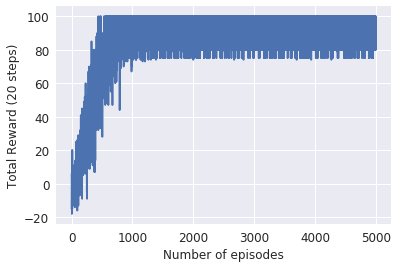

In [35]:
plt.plot(epoch_reward)
plt.ylabel('Total Reward (20 steps)', fontsize=12)
plt.xlabel('Number of episodes', fontsize=12)
plt.show()

## Problem 3 (d)

In [36]:
ac = torch.load('model/vpg/vpg_s1234/pyt_save/model.pt')

In [37]:
dummy_env = gym.make(env_id)
all_obs = dummy_env.all_state

In [38]:
with torch.no_grad():
    value = ac.v(torch.as_tensor(all_obs, dtype=torch.float32))
V = np.reshape(value.numpy(), (dummy_env.h, dummy_env.w))

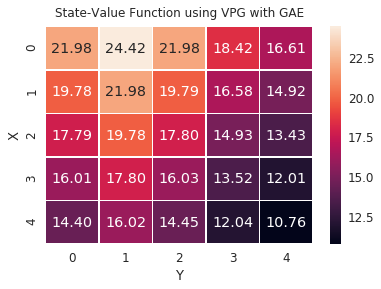

In [39]:
sns.set(font_scale = 1.2)
ax = sns.heatmap(V, annot=True, fmt=".2f", linewidths=.5)
ax.set_title('State-Value Function using VPG with GAE', pad=10, fontsize=12)

# We use the convention followed by numpy, 
# i.e. top-left is (0,0) and x is along the hieght of the grid

ax.set_ylabel('X') # X corresponds to the first dimension
ax.set_xlabel('Y') # Y corresponds to the second dimension
plt.show()